# _Main Notebook_

## Table of Contents:

- [EDA](#eda)
  - [TODO](#subsection-1-1)
- [Communities analysis](#communities)
  - [Setup](#communities_setup)
  - [Interaction Graph](#communites_interaction)
  - [Communities](#communities_communities)
  - [Vote Analysis](#communities_vote)
- [Content of edits analysis](#edits)
  - [Setup](#edits_setup)
  - [Statistics](#edits_statistics)
  - [Investigation of most edited pages](#edits_investigation)

In [1]:
# Imports
import pandas as pd
import sys
sys.path.append('../')
from ada2023.utils import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gzip
from itertools import combinations
from scipy.stats import pearsonr
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.formula.api as smf

# Exploratory Data Analysis <a class="anchor" id="eda"></a>

## 1 : Data Loading

In [2]:
with gzip.open('../data/wiki-RfA.txt.gz', 'rt', encoding='utf-8') as f:
    blocks = f.read().strip().split('\n\n')  # Assuming each record is separated by a blank line

data = []

# Parse each block of text into a dictionary
for block in blocks:
    record = {}
    for line in block.split('\n'):
        if line:
            key, value = line.split(':', 1)  # Split on the first colon only
            record[key.strip()] = value.strip()
    data.append(record)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

#Rename the columns
df.columns = ['source', 'target', 'vote', 'result', 'year_election', 'date_vote', 'comment']

In [3]:
df

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.
198272,Jiang,WhisperToMe,1,1,2003,,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....


## 2 : Preliminary checks

In [4]:
#Create a new dataframe before cleaning the data
new_df = df.copy(deep=True)

### 2.1 : Dive into user name source

In [5]:
#Transform the source column to string
source_cleaned_data = new_df.copy(deep=True)
source_cleaned_data['source'] = source_cleaned_data['source'].astype(str)

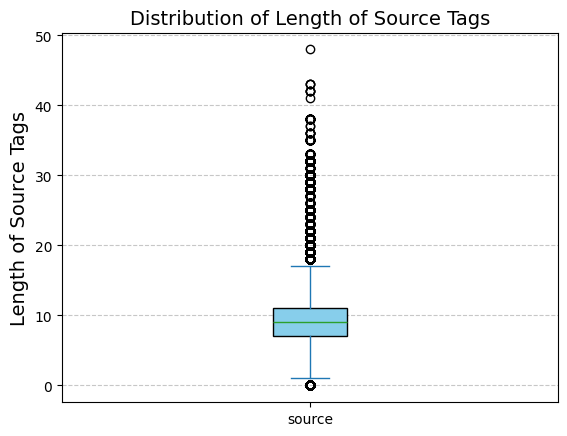

In [6]:
#Look at the distribution of the length of the source tags with a box plot
ax = source_cleaned_data['source'].str.len().plot(kind='box', patch_artist=True, boxprops=dict(facecolor='skyblue'))
ax.set_title('Distribution of Length of Source Tags', fontsize=14)
ax.set_ylabel('Length of Source Tags', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [7]:
#Look at the number of unique source users
unique_voters = source_cleaned_data['source'].nunique()
print(f'The number of unique voters is {unique_voters}')

#Look at the number of null values for the source
nan_source = source_cleaned_data[source_cleaned_data.source == '']['source'].count()
print(f'The number of voters without tags is {nan_source}')

The number of unique voters is 10417
The number of voters without tags is 1661


While examining the outliers in relation to their source tags:

It's observed that outliers possessing source tags longer than 25 characters typically do not present specific issues.
A significant portion of these outliers are identified to have empty source tag lengths. Consequently, we've opted to exclude votes linked with empty source tags. This decision aligns with our objective to utilize the data for community building and to track user interactions. Allowing votes from empty source tags might skew our community analysis, potentially leading to an imbalance where certain users' votes are disproportionately influential compared to others.

In [9]:
#Remove the rows with votes associated to empty source 
source_cleaned_data = source_cleaned_data[source_cleaned_data.source != '']

In [10]:
#Now we look at the other outliers, votes with user tags of length greater than 200
source_cleaned_data[source_cleaned_data.source.str.len() > 20].source.unique()

array(['Pharaoh of the Wizards', "Useight's Public Sock",
       'Brambleberry of RiverClan', 'Sir Nicholas de Mimsy-Porpington',
       'Hullaballoo Wolfowitz', 'The Blade of the Northern Lights',
       'Gareth Griffith-Jones', 'Santa Claus of the Future',
       'You Can Act Like A Man', 'Future Perfect at Sunrise',
       'Lothar von Richthofen', 'GMolewaterdelaRiveBox',
       "Chase me ladies, I'm the Cavalry",
       'Short Brigade Harvester Boris', 'Rannpháirtí anaithnid',
       'Alessandra Napolitano', "Floquenstein's monster",
       'Thine Antique Pen (public)',
       'Department of Redundancy Department', 'Regent of the Seatopians',
       'Catfish Jim and the soapdish', 'Who Am I Why Am I Here',
       'ResidentAnthropologist', 'Physics is all gnomes',
       'DisillusionedBitterAndKnackered', 'PrincessWortheverything',
       'Planetary Chaos Redux', 'The most interesting man in the world',
       'Another Type of Zombie', 'SomeDudeWithAUserName',
       'The High Fin S

Usernames appear accurate and suitable for user tags, and thus do not require removal.


### 2.2 : Dive into target user name

In [12]:
#Make deep copy before cleaning for target
target_cleaned_data = source_cleaned_data.copy(deep=True)

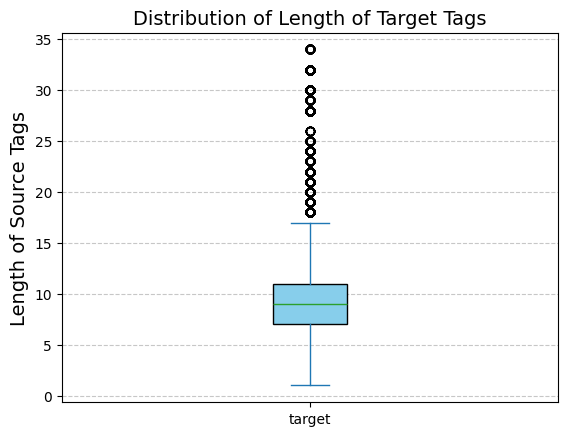

In [13]:
#Look at the distribution of the length of the target tags with a box plot
ax = target_cleaned_data['target'].str.len().plot(kind='box', patch_artist=True, boxprops=dict(facecolor='skyblue'))
ax.set_title('Distribution of Length of Target Tags', fontsize=14)
ax.set_ylabel('Length of Source Tags', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [14]:
#Look at the number of unique target users
unique_electives = target_cleaned_data['target'].nunique()
print(f'The number of unique users running for election is {unique_electives}')

#Look at the number of null values for the source
nan_target = target_cleaned_data[target_cleaned_data.target == '']['target'].count()
print(f'The number of nan values for the target is {nan_target}')

The number of unique users running for election is 3491
The number of nan values for the target is 0


In [15]:
new_df[new_df.target.str.len() > 20].target.unique()

array(['Catfish Jim and the soapdish', 'Rannpháirtí anaithnid',
       'The Blade of the Northern Lights', 'Who Am I Why Am I Here',
       'Marcus Aurelius Antoninus', 'PopMusicWillNeverBeLowBrow',
       'RandomStringOfCharacters', 'The High Fin Sperm Whale',
       'The Thing That Should Not Be', 'Wiki Greek Basketball',
       'Backslash Forwardslash', 'Alexander.hugh.george',
       'I Seek To Help & Repair!', 'Raiku Lucifer Samiyaza',
       'The Black Rabbit of Inlé', 'crimsonterminator1000',
       'How do you turn this on', 'Imperial Star Destroyer',
       'Inferno, Lord of Penguins', 'Joseph Solis in Australia',
       'Jupiter Optimus Maximus', "Milk's Favorite Cookie",
       "Sock's Favorite Puppet", 'The Great Editor In Chief',
       'WeBuriedOurSecretsInTheGarden',
       "Chase me ladies, I'm the Cavalry", 'Faithlessthewonderboy',
       'Jaranda (reconfirmation)', 'A Raider Like Indiana',
       'Ineversigninsodonotmessageme', 'SpecialAgentUncleTito',
       "The Rav

Usernames appear accurate and suitable for user tags, and thus do not require removal.

### 2.3 : Check the date and time of votes :

In [16]:
date_cleaned_data = target_cleaned_data.copy(deep=True)

In [17]:
# Define a function to extract date components
def extract_date_components(date_str):
    try:
        # Split the date string by the comma and space to separate time and date parts
        time_part, date_part = date_str.split(', ')
        # Split the time part by the colon to separate hours and minutes
        hour, minute = time_part.split(':')
        # Split the date part by space to separate day, month, and year
        day, month, year = date_part.split(' ')
        
        return pd.Series({
            "hour": hour,
            "minute": minute,
            "day": day,
            "month": month,
            "year_vote": year
        })
    except ValueError:
        # If there is a ValueError, return None for each component
        return pd.Series({
            "hour": None,
            "minute": None,
            "day": None,
            "month": None,
            "year_vote": None
        })

# Apply the function to each row in the 'date' column
date_components = date_cleaned_data['date_vote'].apply(extract_date_components)

# Concatenate the new DataFrame with the original one (if needed)
date_cleaned_data = pd.concat([date_cleaned_data, date_components], axis=1)

date_cleaned_data

,source,target,vote,result,year_election,date_vote,comment,hour,minute,day,month,year_vote
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,23,13,19,April,2013
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,01,04,20,April,2013
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,23,43,19,April,2013
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,00,11,20,April,2013
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",00,56,20,April,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support,02,51,2,Sep,2003
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.,23,45,26,Nov,2003
198272,Jiang,WhisperToMe,1,1,2003,,Support. --,None,None,None,None,None
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....,05,38,5,Dec,2003


In [18]:
#Look at the proportion of rows with missing date_vote
non_date_votes = date_cleaned_data[date_cleaned_data.date_vote == ''].date_vote.count()
total_count = date_cleaned_data.date_vote.count()
print(f'The number of votes for which the date is missing or incorrect is {non_date_votes}')
print(f'This represents {(non_date_votes/total_count)*100:.2f}% of the data.')

The number of votes for which the date is missing or incorrect is 7706
This represents 3.92% of the data.


In [19]:
#Remove the rows with missing date_vote
date_cleaned_data = date_cleaned_data[date_cleaned_data.date_vote != '']

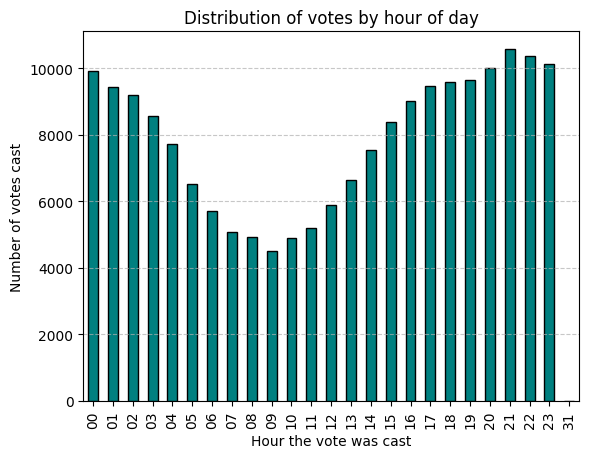

In [20]:
#Look at the distribution for the values of the hour with histogram
date_cleaned_data['hour'].value_counts().sort_index().plot(kind='bar' , color = 'teal' ,  edgecolor='black')
plt.xlabel('Hour the vote was cast')
plt.ylabel('Number of votes cast')
# Set a grid for easier reference to the quantities
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Distribution of votes by hour of day')
plt.show()

In [21]:
#Proportion of rows with the hour value as 31
print(f'The proportion of rows with the hour value as 31 is {date_cleaned_data[date_cleaned_data.hour == "31"]["hour"].count()/date_cleaned_data["hour"].count()}')

The proportion of rows with the hour value as 31 is 5.293582061109111e-06


In this dataset, there are a small fraction of votes occurring at the 31st hour, which is not a valid time. Given that the number of occurrences is negligible, we have chosen to exclude this data point from the dataframe. This removal is unlikely to affect the overall analysis of the dataset due to its minimal incidence.

In [22]:
#Remove from the dataframe the rows with the value of the hour as 31
date_cleaned_data = date_cleaned_data[date_cleaned_data['hour'] != '31']

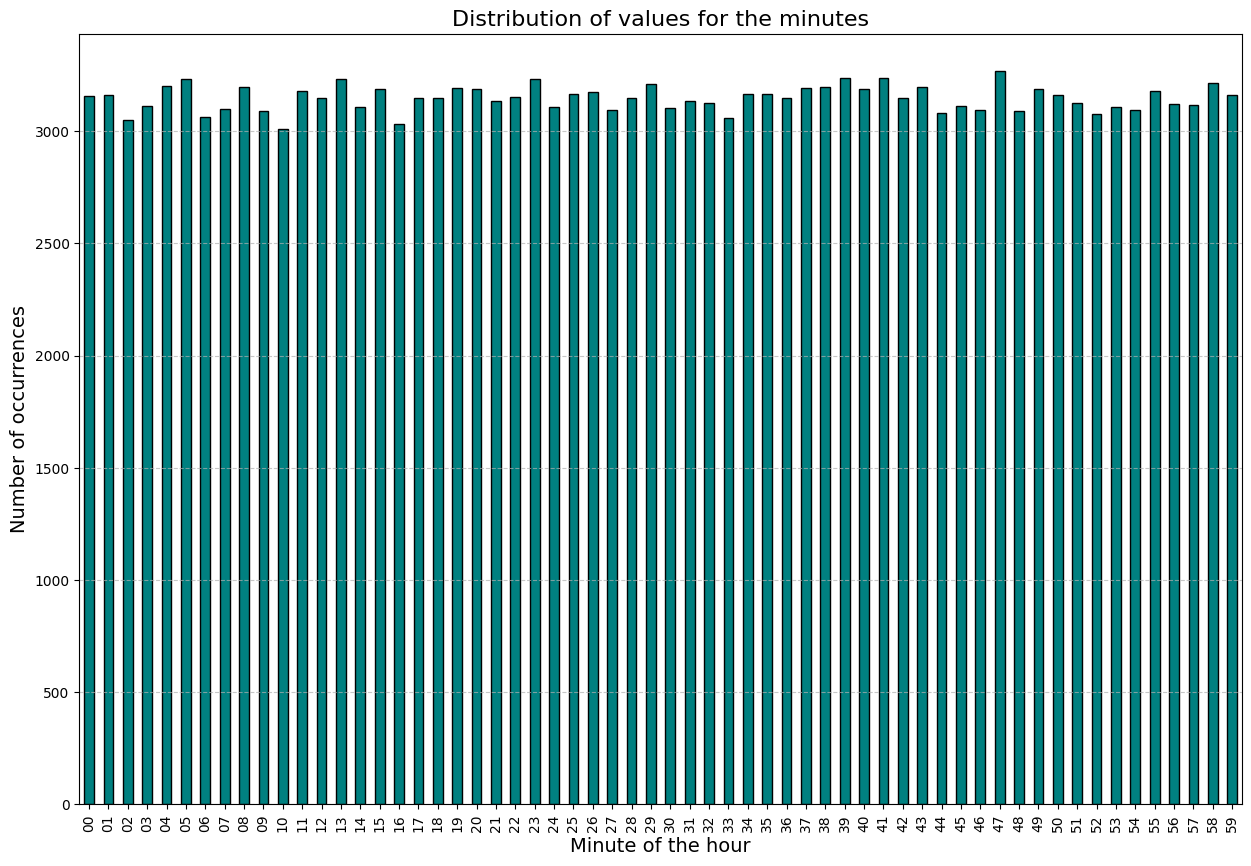

In [23]:
# Set the figure size for better visibility
plt.figure(figsize=(15, 10))

ax = date_cleaned_data['minute'].value_counts().sort_index().plot(kind='bar', color='teal', edgecolor='black')

ax.set_xlabel('Minute of the hour', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the minutes', fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

The minute values appear to be in order, and their distribution is evenly spread, which aligns with expectations.



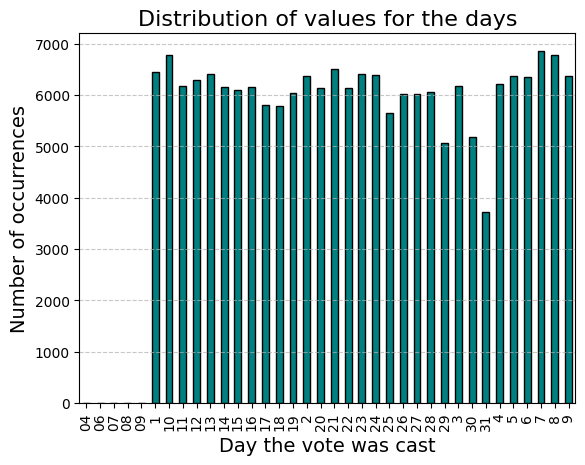

In [24]:
#Look at the distribution of the values for the days with histogram and order the values

ax = date_cleaned_data['day'].value_counts().sort_index().plot(kind='bar' ,  color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Day the vote was cast', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the days', fontsize=16)

plt.show()

The values for the day also seem to be correct.



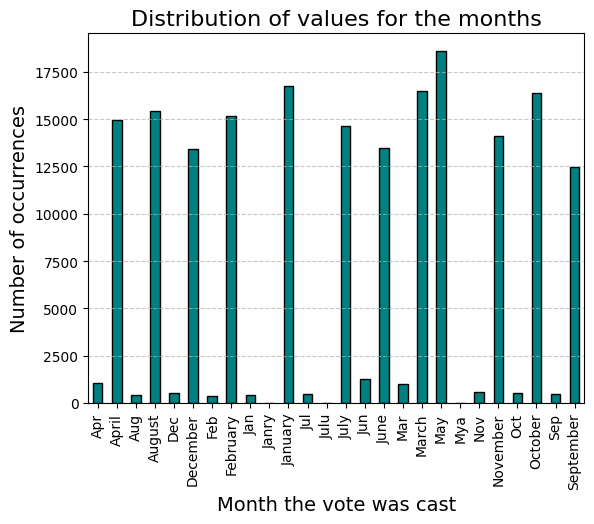

In [25]:
#Look at the distribution of the values for the months with histogram and order the values
ax = date_cleaned_data['month'].value_counts().sort_index().plot(kind='bar' , color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Month the vote was cast', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the months', fontsize=16)

plt.show()

The dataset displays variations in the representation of specific months. For instance, the month of July is listed as 'Jul,' 'Julu,' and 'July'; similarly, October is noted as 'Oct' and 'October.'

In [26]:
#Map the values of the months to the full name of the month
month_map = { 
    "Apr" : "April",
    "April" : "April",
    "Aug" : "August",
    "August" : "August",
    "Dec" : "December",
    "December" : "December",
    "Feb" : "February",
    "February" : "February",
    "Jan" : "January",
    "Janry" : "January",
    "January" : "January",
    "Jul" : "July",
    "Julu" : "July",
    "July" : "July",
    "Jun" : "June",
    "June" : "June",
    "Mar" : "March",
    "March" : "March",
    "May" : "May",
    "Mya" : "May",
    "Nov" : "November",
    "November" : "November",
    "Oct" : "October",
    "October" : "October",
    "Sep" : "September",
    "September" : "September"
}

def correction_month (month) : 
    return month_map.get(month, month)

date_cleaned_data['month'] = date_cleaned_data['month'].apply(correction_month)
date_cleaned_data

,source,target,vote,result,year_election,date_vote,comment,hour,minute,day,month,year_vote
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,23,13,19,April,2013
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,01,04,20,April,2013
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,23,43,19,April,2013
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,00,11,20,April,2013
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",00,56,20,April,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
198267,Hephaestos,Ugen64,1,1,2003,"16:05, 6 Dec 2003",Also support; seems like a good contributor. -,16,05,6,December,2003
198269,Cyan,Vancouverguy,1,1,2003,"02:13, 31 Aug 2003",Support. --,02,13,31,August,2003
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support,02,51,2,September,2003
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.,23,45,26,November,2003


The values for the years seems also to be ok.



In [27]:
date_cleaned_data['date_vote'] = pd.to_datetime(date_cleaned_data['day'].astype(str) + ' ' +
                            date_cleaned_data['month'].astype(str) + ' ' +
                            date_cleaned_data['year_vote'].astype(str) + ' ' +
                            date_cleaned_data['hour'].astype(str) + ':' +
                            date_cleaned_data['minute'].astype(str),
                            format='%d %B %Y %H:%M' , errors = 'coerce')

date_cleaned_data.drop(['hour', 'minute', 'day', 'month', 'year_vote'], axis=1, inplace=True)
date_cleaned_data

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198267,Hephaestos,Ugen64,1,1,2003,2003-12-06 16:05:00,Also support; seems like a good contributor. -
198269,Cyan,Vancouverguy,1,1,2003,2003-08-31 02:13:00,Support. --
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.


### 2.4 : Dive into the year_election values

In [28]:
year_elections_cleaned_data = date_cleaned_data.copy(deep=True)

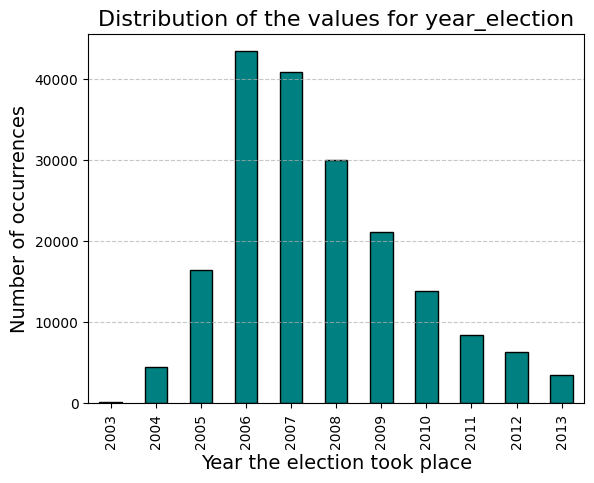

In [30]:
#Look at the distribution of the values for year_election
year_elections_cleaned_data['year_election'] = year_elections_cleaned_data['year_election'].astype(int)


ax = year_elections_cleaned_data['year_election'].value_counts().sort_index().plot(kind='bar' , color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Year the election took place', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of the values for year_election', fontsize=16)

plt.show()

### 2.5 : Dive into the vote and results values


In [31]:
vote_results_data_cleaned = year_elections_cleaned_data.copy(deep=True)

count    188907.000000
mean          0.522331
std           0.815787
min          -1.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: vote, dtype: float64


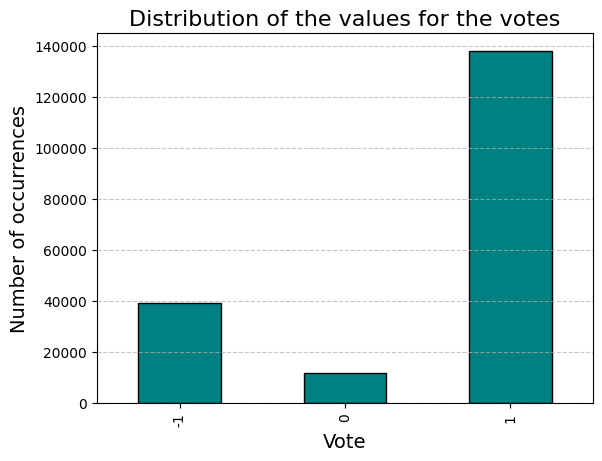

In [32]:
#Look at the distribution of the values for the vote
vote_results_data_cleaned['vote'] = vote_results_data_cleaned['vote'].astype(int)
vote_results_data_cleaned['result'] = vote_results_data_cleaned['result'].astype(int)

print(vote_results_data_cleaned['vote'].describe())
ax = vote_results_data_cleaned['vote'].value_counts().sort_index().plot(kind='bar' , color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Vote', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of the values for the votes', fontsize=16)

plt.show()

In [33]:
value_perc_vote = vote_results_data_cleaned['vote'].value_counts(normalize=True) * 100

# Print the percentages
print("Percentage of Each Unique Value in vote:")
print(value_perc_vote)

Percentage of Each Unique Value in vote:
vote
 1    73.033292
-1    20.800182
 0     6.166526
Name: proportion, dtype: float64


count    188907.000000
mean          0.240642
std           0.970616
min          -1.000000
25%          -1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: result, dtype: float64


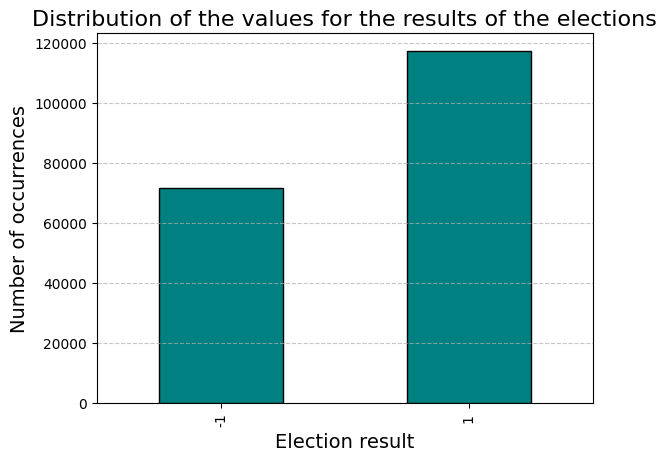

In [34]:
#Look at the distribution of the values for the result
print(vote_results_data_cleaned['result'].describe())
ax = vote_results_data_cleaned['result'].value_counts().sort_index().plot(kind='bar' , color='teal', edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Election result', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of the values for the results of the elections', fontsize=16)

plt.show()
plt.show()

In [35]:
value_perc_result = vote_results_data_cleaned['result'].value_counts(normalize=True) * 100

# Print the percentages
print("Percentage of Each Unique Value in result:")
print(value_perc_result)

Percentage of Each Unique Value in result:
result
 1    62.032111
-1    37.967889
Name: proportion, dtype: float64


### 2.6 : Dive into comments

The percentage of empty comments is 2.31%


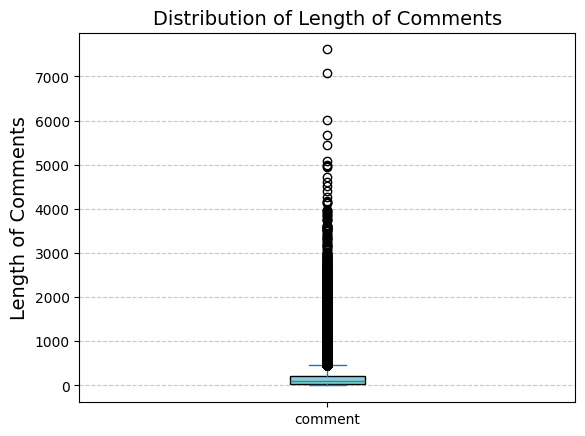

In [36]:
#Look at the proportion of empty comments
print(f'The percentage of empty comments is {vote_results_data_cleaned[vote_results_data_cleaned.comment == ""]["comment"].count()/vote_results_data_cleaned["comment"].count() * 100:.2f}%')

#Look at the disribution of the length of the comments
ax = vote_results_data_cleaned['comment'].str.len().plot(kind='box', patch_artist=True, boxprops=dict(facecolor='skyblue'))
ax.set_title('Distribution of Length of Comments', fontsize=14)
ax.set_ylabel('Length of Comments', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [37]:
cleaned_df = vote_results_data_cleaned.copy(deep=True)

#Store the cleaned dataframe in a csv file
cleaned_df.to_csv('../data/wiki-RfA-cleaned.csv', index=False)

## 3. Voting results analysis

In [39]:
#Import the cleaned dataframe
analysis_df = pd.read_csv('../data/wiki-RfA-cleaned.csv')

In [40]:
analysis_df['date_vote'] = pd.to_datetime(analysis_df['date_vote'])

### 3.1 : User behavior

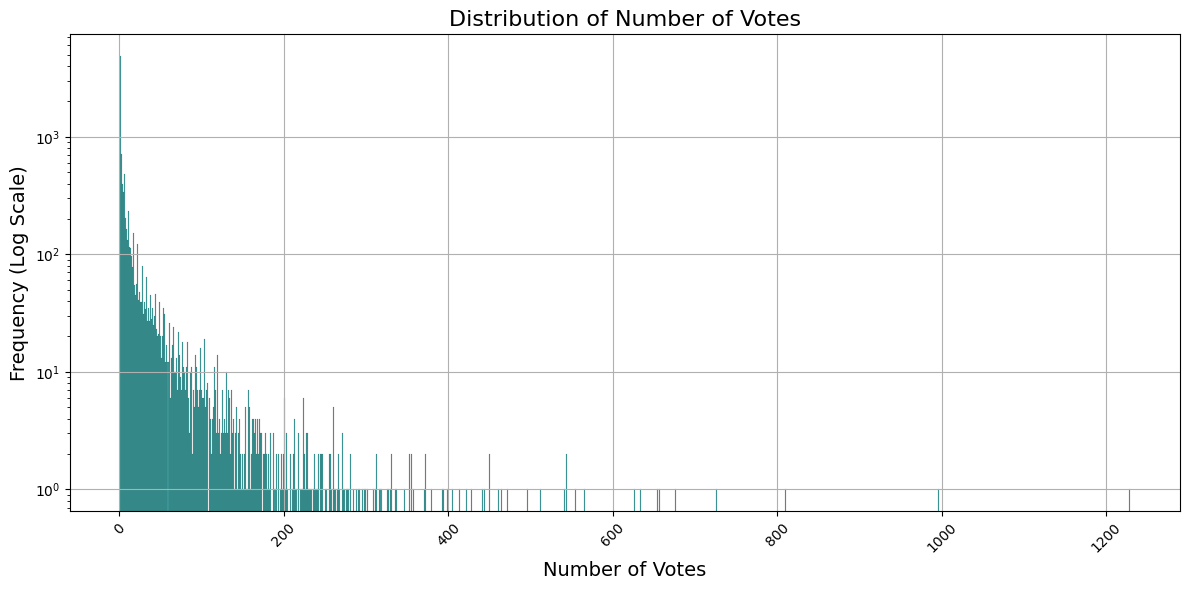

In [41]:
#First we plot the distribution of the number of votes per user

grouped_per_user = analysis_df.groupby('source').apply(lambda x : pd.Series({
    'number_of_votes' : len(x['target'])})).reset_index()

# Set the size of the figure
plt.figure(figsize=(12, 6))

# Create the histogram
ax = sns.histplot(grouped_per_user['number_of_votes'], color='teal', log=True, bins=1000, edgecolor='black')

ax.set_title('Distribution of Number of Votes', fontsize=16)  
ax.set_xlabel('Number of Votes', fontsize=14)  
ax.set_ylabel('Frequency (Log Scale)', fontsize=14) 
ax.grid(True) 
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

We can see a classic long-tail distribution of voter activity, indicative of a pattern where a small number of individuals account for a disproportionately large number of votes, while the vast majority participate minimally. The steep decline and subsequent long tail to the right suggest that the community has a few highly engaged users, a common trait in voluntary, community-driven platforms. This could imply that engagement initiatives might focus on the more active users to leverage their influence, or conversely, on the less active majority to increase overall participation.

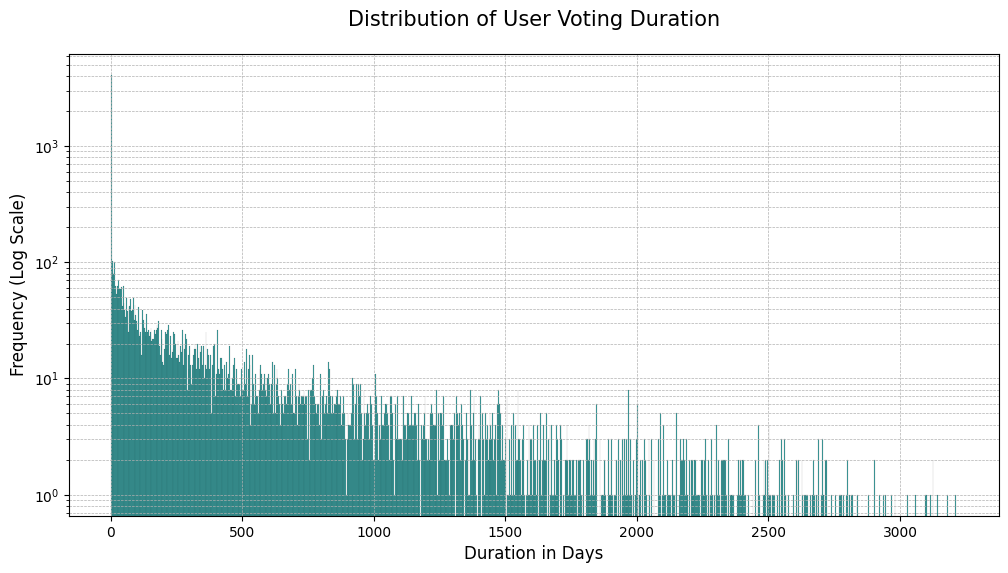

In [42]:
date_analysis = analysis_df.groupby('source').apply(lambda x : pd.Series({
    'sequence_of_votes' : x['date_vote'].values})).reset_index()

def calculation_duration (dates) : 
     
    sorted_dates = sorted(dates)
    return (sorted_dates[-1] - sorted_dates[0])

date_analysis['duration'] = date_analysis['sequence_of_votes'].apply(calculation_duration)

#Look into the distribution of the duration of the sequence of votes
# Set the size of the figure

plt.figure(figsize=(12, 6))

# Create the histogram
ax = sns.histplot(date_analysis['duration'].dt.days, color='teal', log =True,bins = 1000,  edgecolor='black')

# Improve layout and aesthetics
ax.set_title('Distribution of User Voting Duration', fontsize=15, pad=20)
ax.set_xlabel('Duration in Days', fontsize=12)
ax.set_ylabel('Frequency (Log Scale)', fontsize=12)
ax.grid(True, which="both", ls="--", linewidth=0.5)

# Show the plot
plt.show()

The histogram depicting the duration between users' first and last votes confirms the conclusion form the previous plot : most users engage in a short burst of activity, casting votes for a brief period before becoming inactive, as shown by the numerous tall bars at the plot's start. This trend aligns with the initial surge of participation seen in the previous plot, where many users voted only a few times. Conversely, the long tail in both plots points to a subset of dedicated users who not only vote more frequently but also stay active over long stretches, suggesting a core group's persistent engagement shapes the platform's voting landscape. Together, these insights reveal a pattern of engagement where a small cohort of users provides ponctual votes and others who have a really important impact.

       estimated_number_elections
count                 3468.000000
mean                     1.197809
std                      0.529571
min                      1.000000
25%                      1.000000
50%                      1.000000
75%                      1.000000
max                      7.000000


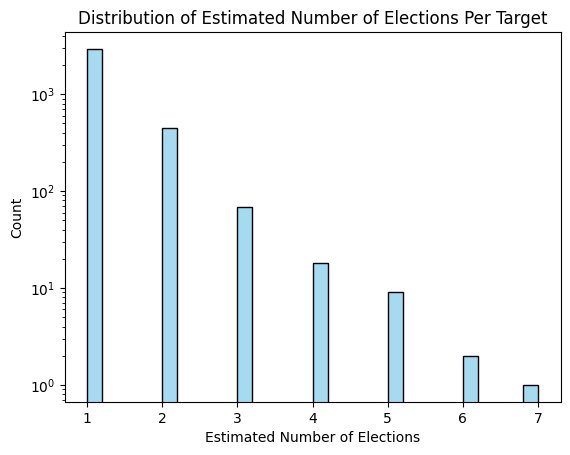

In [43]:
#Now to get an inuition about the average number of election that a user runs for
#As we know that an RfA is on average 7 days, we will set this specific time lapse as the duration of an election

def estimate_number_of_elections(group):
    # Ensure the dates are sorted
    sorted_dates = group.sort_values()
    
    # Initialize the count of elections and set the first election start date
    elections_count = 1
    election_start = sorted_dates.iloc[0]

    for date in sorted_dates[1:]:
        # If the current vote is more than a week after the election start, count a new election
        if (date - election_start).days > 7:
            elections_count += 1
            election_start = date

    return elections_count

# Apply the function to each group and create a new column with the estimated number of elections
estimated_number_elections_per_user = analysis_df.groupby('target')['date_vote'].apply(estimate_number_of_elections).reset_index().rename(columns={'date_vote': 'estimated_number_elections'})

#We look at the distribution of values for the estimated number of elections
print(estimated_number_elections_per_user.describe())

#We look at the distribution of values for the estimated number of elections
sns.histplot(estimated_number_elections_per_user.estimated_number_elections, bins=30, kde=False, color='skyblue', log = True)
plt.title('Distribution of Estimated Number of Elections Per Target')
plt.xlabel('Estimated Number of Elections')
plt.ylabel('Count')
plt.show()

The histogram and descriptive statistics indicate that the majority of targets in the dataset are estimated to have run for just one election, which is consistent with the data's mean and mode both being close to 1. The significant drop-off after one election suggests that it is much less common for targets to run multiple times. With over 75% of the targets estimated to have participated in only one election, there's a clear indication that repeated runs for election are rare. This aligns with the earlier plots showing that while there are a few highly active and engaged individuals, the vast majority have lower levels of activity. In this context, the repeated candidacies could be attributed to a similarly small group of individuals who are highly involved in the community, repeatedly seeking election, reflecting a pattern of engagement where a core group of users is significantly more active than the rest.

In [47]:
# Get the users who ran for election only once
ran_once = estimated_number_elections_per_user[estimated_number_elections_per_user.estimated_number_elections == 1]

# Get the users who ran for election only once and did not get elected
not_elected_once = ran_once[~ran_once.target.isin(analysis_df[analysis_df.result == 1].target)]

number_unique_people_running = analysis_df.target.nunique()
print(f'The proportion of users that give up after one election is {len(not_elected_once)/number_unique_people_running*100:.2f}%')

The proportion of users that give up after one election is 39.07%


The statistic that 39% of voters do not participate in subsequent elections if they don't succeed in their first attempt is indicative of a high dropout rate, potentially reflecting various underlying factors. This rate suggests a significant level of voter apathy or disillusionment, possibly arising from a perception that their vote lacks impact or from a general lack of sustained motivation. This statistic also poses questions about the evolving nature of voter engagement and the effectiveness of current electoral systems in sustaining voter interest and belief in the electoral process.

### 3.2 : Election dynamics

In [48]:
elect_dynamics_df = analysis_df.copy(deep=True)

In [49]:
#We set an id fo each of the election following the method used before in order to compute further statistics regarding the elections
# Sort the dataframe by 'target' and 'date_vote'
elect_dynamics_df.sort_values(by=['target', 'date_vote'], inplace=True)

# Initialize a counter for the global election ID
global_election_id = 0
# Initialize the last seen election date for each target
last_election_date = elect_dynamics_df.groupby('target')['date_vote'].first() - pd.Timedelta(days=8)

# Function to assign election ids
def assign_election_ids(row):
    global global_election_id
    # If the current vote date is more than 7 days after the last election date for this target
    if (row['date_vote'] - last_election_date[row['target']]).days > 7:
        global_election_id += 1
        last_election_date[row['target']] = row['date_vote']
    return global_election_id

# Apply the function to each row
elect_dynamics_df['global_election_id'] = elect_dynamics_df.apply(assign_election_ids, axis=1)

In [50]:
elect_dynamics_df


,source,target,vote,result,year_election,date_vote,comment,global_election_id
124379,Dbiv,(aeropagitica),1,1,2006,2006-02-28 00:09:00,"'''Support'''. Yippee, I get to be the first!",1
124380,King of Hearts,(aeropagitica),1,1,2006,2006-02-28 01:11:00,"'''Support''' as nominator, of course. --",1
124381,Blnguyen,(aeropagitica),1,1,2006,2006-02-28 01:32:00,"'''Support''' have seen this chap around, help...",1
124415,ILovePlankton,(aeropagitica),-1,1,2006,2006-02-28 02:05:00,'''Oppose''' Not enough interaction with other...,1
124382,Zsinj,(aeropagitica),1,1,2006,2006-02-28 02:50:00,"'''Support''', even though the majority of edi...",1
...,...,...,...,...,...,...,...,...
180516,mikkalai,Ђорђе Д. Божовић,-1,-1,2005,2005-11-27 17:16:00,'''Oppose''': The person is simply unknown to ...,4154
180517,Sarahe,Ђорђе Д. Божовић,-1,-1,2005,2005-11-28 00:05:00,"'''Oppose''' as per jkelly, JIP and Kelly Mart...",4154
180518,NormanEinstein,Ђорђе Д. Божовић,-1,-1,2005,2005-11-30 15:08:00,'''Oppose''' per JIP. --,4154
180504,Jobe6,Ђорђе Д. Божовић,1,-1,2005,2005-11-30 23:56:00,'''Support''' reasons for oppose are somewhat ...,4154


In [51]:
#We compute here different statistics
elect_dynamics_df = elect_dynamics_df.groupby(['global_election_id']).apply(lambda x : pd.Series({
    'number_of_votes' : len(x['source']), 
    'ratio_positive_votes' : x[x.vote == 1]['vote'].sum() / len(x.source), 
    'ratio_neutral_votes' : x[x.vote == 0]['vote'].sum() / len(x.source),
    'average_comment_length' : x['comment'].str.len().mean(),
    'date_last_vote' : x['date_vote'].max(),
    'result' : x['result'].max(),
    'year_election' : x['year_election'].max(),
})).reset_index()
elect_dynamics_df

,global_election_id,number_of_votes,ratio_positive_votes,ratio_neutral_votes,average_comment_length,date_last_vote,result,year_election
0,1,51,0.705882,0.0,109.000000,2006-03-06 22:36:00,1,2006
1,2,6,0.000000,0.0,278.500000,2010-09-29 20:50:00,-1,2010
2,3,6,0.000000,0.0,275.333333,2010-05-20 00:57:00,-1,2010
3,4,6,1.000000,0.0,40.000000,2003-12-05 05:39:00,1,2003
4,5,24,0.166667,0.0,324.833333,2008-03-19 19:55:00,-1,2008
...,...,...,...,...,...,...,...,...
4149,4150,2,0.000000,0.0,353.000000,2006-06-13 06:23:00,-1,2006
4150,4151,14,0.785714,0.0,117.090909,2004-05-20 18:30:00,1,2004
4151,4152,68,0.544118,0.0,225.923077,2005-10-16 00:41:00,-1,2005
4152,4153,217,0.635945,0.0,247.189815,2012-10-09 01:42:00,-1,2012


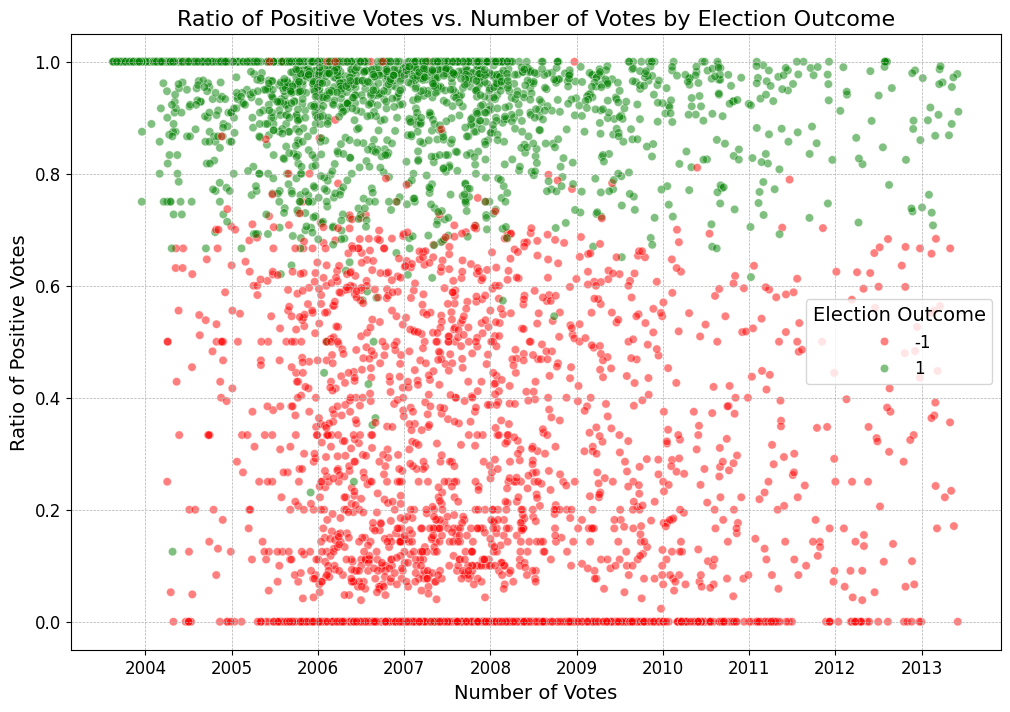

In [52]:
#Plot the ratio of positive votes for each election, an election is identified by the year of the result and the target
# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Create the scatter plot
sns.scatterplot(x='date_last_vote',
                y='ratio_positive_votes', 
                hue='result', 
                data=elect_dynamics_df,
                palette=['red', 'green'], 
                alpha=0.5)  

# Enhance plot aesthetics
plt.title('Ratio of Positive Votes vs. Number of Votes by Election Outcome', fontsize=16)
plt.xlabel('Number of Votes', fontsize=14)
plt.ylabel('Ratio of Positive Votes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Election Outcome', fontsize=12, title_fontsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

The scatter plot illustrates a correlation between the ratio of positive votes and election outcomes, with a dense cluster of green dots at higher ratios indicating wins and red dots at lower ratios indicating losses. As the number of votes increases, there seems to be a trend toward more wins, shown by the prevalence of green dots in areas with a greater number of votes. Elections with a moderate ratio of positive votes show a mix of outcomes, reflecting the competitive nature of those elections. Overall, the plot suggests that while a higher number of votes is generally favorable, the ratio of positive votes is a strong indicator of success in elections, as most wins are concentrated in the region with higher positive vote ratios

Seems like there is a specific threshold for the percentage of positive votes for an election to be successfull.

In [54]:
#Compute the correlation between the ratio of positive votes and the outcome of the election
stats.pearsonr(elect_dynamics_df['ratio_positive_votes'], elect_dynamics_df['result'])

PearsonRResult(statistic=0.8687042654781572, pvalue=0.0)

In [55]:
regression_df = elect_dynamics_df.copy(deep=True)
regression_df['result'] = regression_df['result'].replace({-1 : 0})
mod = smf.logit(formula='result ~  (year_election) + number_of_votes + ratio_positive_votes + \
                          + ratio_positive_votes + average_comment_length' , data=regression_df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.116421
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 4149
Model:                          Logit   Df Residuals:                     4144
Method:                           MLE   Df Model:                            4
Date:                Fri, 17 Nov 2023   Pseudo R-squ.:                  0.8318
Time:                        09:07:26   Log-Likelihood:                -483.03
converged:                       True   LL-Null:                       -2871.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 19.7699    114.721      0.172      0.863    -205.078     

Model Fit: The R-squared value is 0.8318, which is high, suggesting that the model fits the data well.

Significance: The LLR (likelihood ratio test) p-value is less than 0.05, indicating that the model as a whole is statistically significant compared to the null model.

Regarding the different coefficients :

The ratio_positive_votes coefficient is significant (p < 0.05) and positive, indicating that as the ratio of positive votes increases, the log-odds of winning the election (result=1) significantly increase.
The year_election, number_of_votes, and average_comment_length coefficients are not statistically significant (p > 0.05), implying that these variables do not have a significant impact on the log-odds of the election outcome in the presence of other variables.
Intercept: The intercept is also not significant, which is not typically a concern as it simply sets the baseline log-odds of the outcome when all predictors are at zero.

In summary, the model strongly suggests that the ratio of positive votes is a key predictor of election outcomes, while other variables like the year of the election, the number of votes, and the average comment length do not show a significant relationship in this logistic regression model. The presence of quasi-separation suggests that while the model fits the current data well, it might not generalize well to new data.

## 4 : Number of votes analysis

In [56]:
elect_dynamics_df['year_election'].unique().sort()

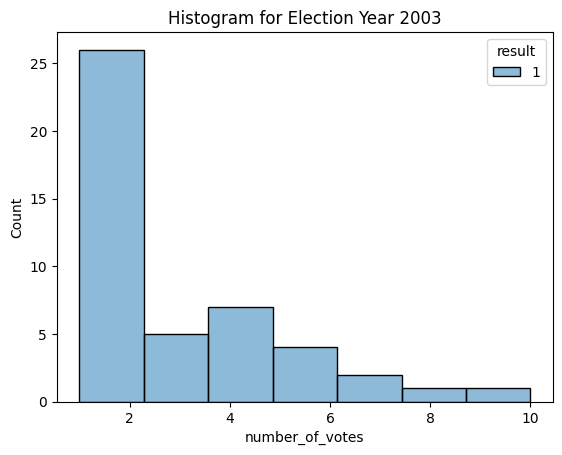

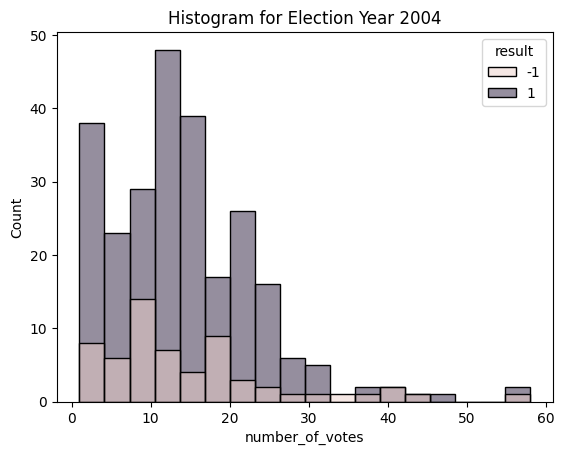

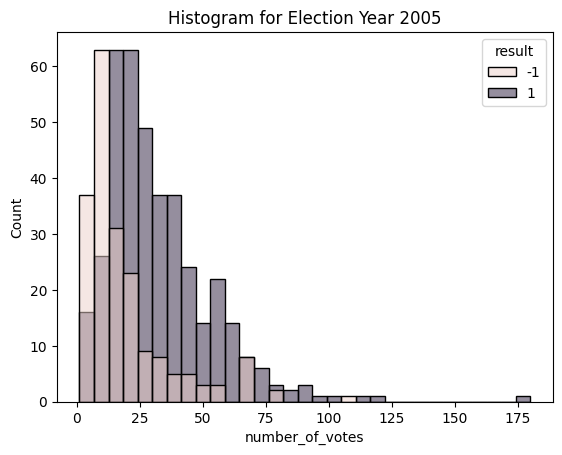

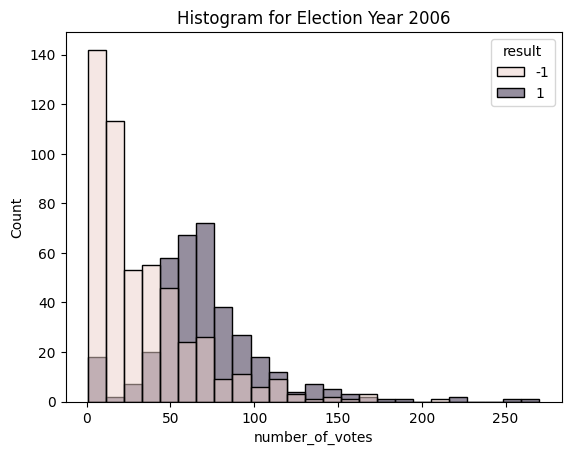

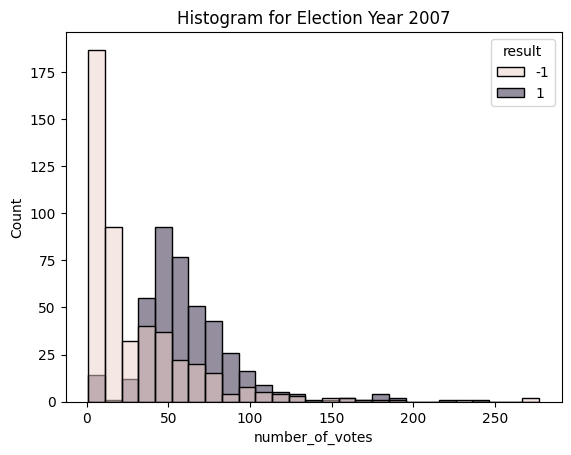

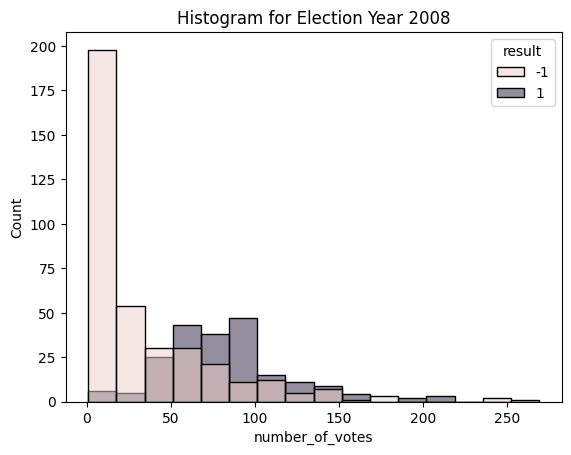

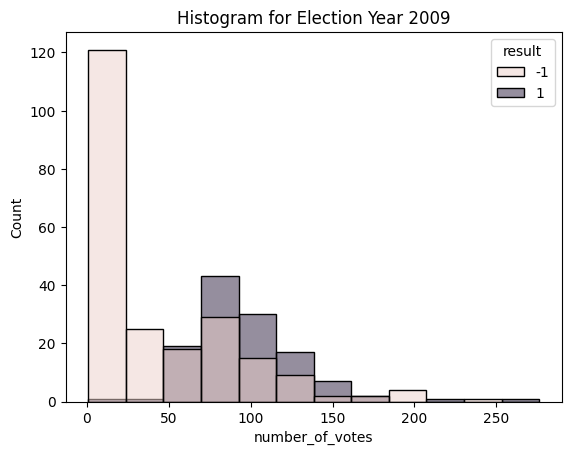

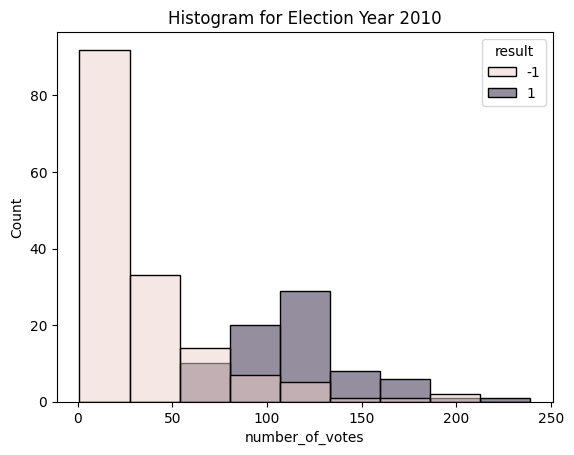

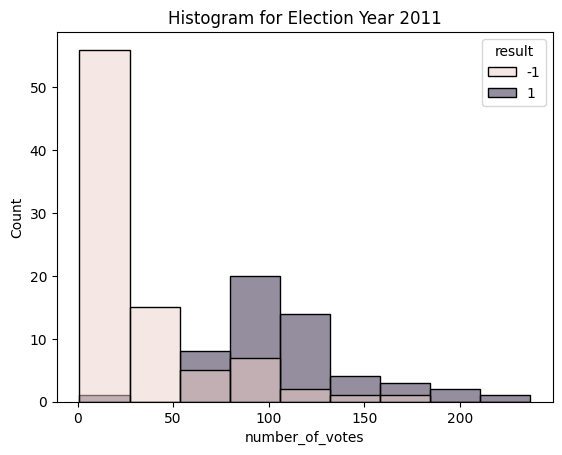

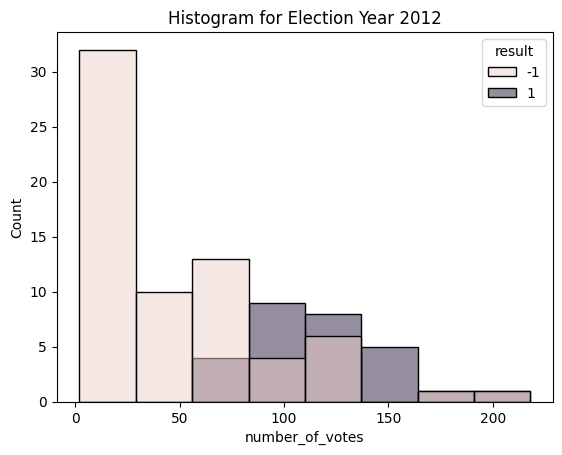

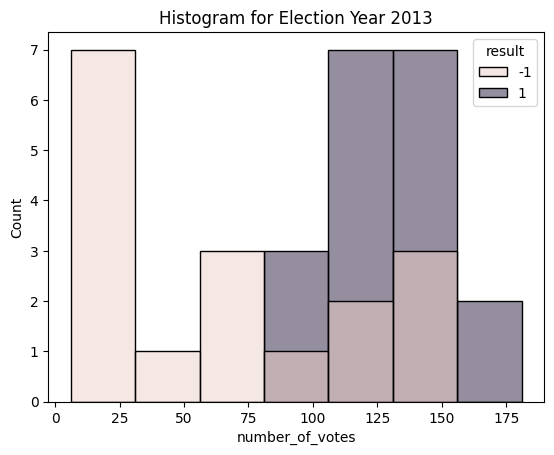

In [58]:
# Assuming 'election_year' is of type int
for year in sorted(elect_dynamics_df['year_election'].unique()):
    data_subset = elect_dynamics_df[elect_dynamics_df['year_election'] == year]
    
    sns.histplot(x='number_of_votes', data=data_subset, hue='result', log_scale=(False, False), color = 'skyblue', edgecolor='black')
    plt.title(f'Histogram for Election Year {int(year)}')
    plt.show()

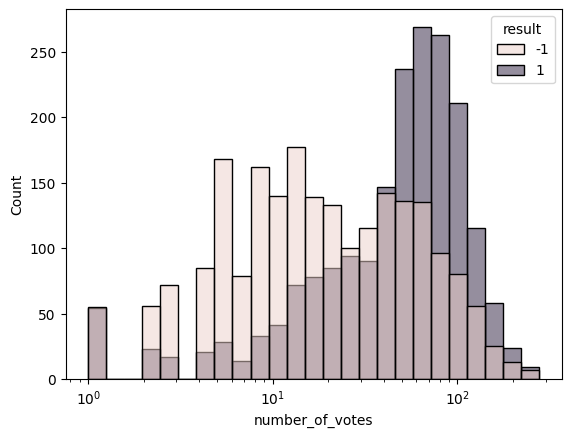

In [61]:
sns.histplot(x = 'number_of_votes', data = elect_dynamics_df , hue = 'result', log_scale= (True, False))
plt.show()


In [62]:
print(new_df.groupby(["target", "result"])["source"].count().median())
print(new_df.groupby(["target", "result"])["source"].count().mean())

42.0
53.11411733190464


# Communities Analysis <a class="anchor" id="communities"></a>

### Setup <a class="anchor" id="communities_setup"></a>

We process the Wikipedia Request for Adminship (RfA) dataset into a dataframe. We are using a [Wikipedia edit history dataset](https://snap.stanford.edu/data/wiki-meta.html) containing edit up to january 2008. Therefore we filter votes that aren't present in this timeframe.

In [2]:
df = pd.read_csv("../data/wiki-RfA-cleaned.csv")

# We filter out all the votations after 2008 as we do not have the edits for those dates
df = df[df.year_election < 2009]

#Set of users that are present in the adminship dataset
admin_set = set(df['source'].to_list() + df['target'].to_list())

In [41]:
print(f"Number of users present in the adminship dataset : {len(admin_set)}")

Number of users present in the adminship dataset : 8494


### Interaction Graph <a class="anchor" id="communities_interaction"></a>

We consider an interaction between two users to be an edit from user A in the user talk page of user B. User talk page ["normal use is for messages from, and discussion with, other editors"](https://en.wikipedia.org/wiki/Wikipedia:User_pages). We filtered edits to keep only interactions from users that where present in the RfA dataset. Using those interactions we created an undirected graph where the weight is the number of interaction between the two users and each node is a user.

In [4]:
G = create_interaction_graph()

In [5]:
print(f"Number of nodes (users) in the graph : {len(G)}")
print(f"Number of users in the RfA dataset : {len(admin_set)}")
print(f"Percentage of users in the graph : {(len(G)/len(admin_set)):.2%}")

Number of nodes (users) in the graph : 6491
Number of users in the RfA dataset : 8494
Percentage of users in the graph : 76.42%


To have a better understanding of the interactions, we plot them in a graph. We also plot the degree rank plot and histogram. The degree of a node is the number of edges adjacents to the node. This plot helps us to better understand the distribution of the number of adjacent nodes. We can see that most of the nodes have a low rank.

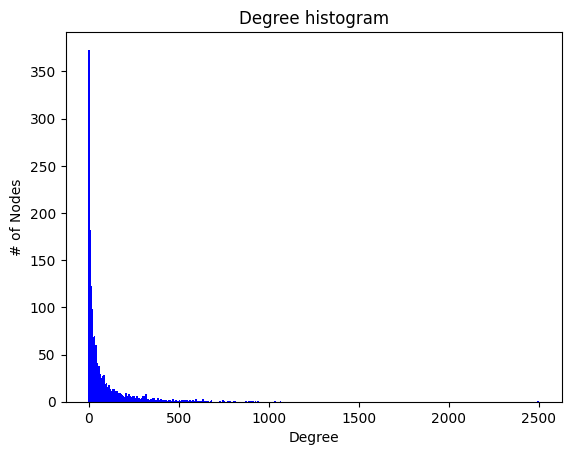

In [6]:
# We sort the nodes in the graph by their degree
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
unique_degree, counts = np.unique(degree_sequence, return_counts=True)

# Degree histogram
plt.bar(unique_degree, counts,width=10, color='b')
plt.title("Degree histogram")
plt.xlabel("Degree")
plt.ylabel("# of Nodes")

plt.show()

### Communities <a class="anchor" id="communities_communities"></a>

We explore the relationship between users by creating communities. Communities are created using Louvain algorithm that "[works in 2 steps. On the first step it assigns every node to be in its own community and then for each node it tries to find the maximum positive modularity gain by moving each node to all of its neighbor communities. If no positive gain is achieved the node remains in its original community](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html)"

In [7]:
#We create the communities

communities = nx.community.louvain_communities(G, resolution=1.5, seed=2)

In [8]:
print(f"Number of communities in graph of users with interactions : {len(communities)}")

Number of communities in graph of users with interactions : 29


In [9]:
for i, c in enumerate(communities):
    print(f"Community {i} has size {len(c)}")

Community 0 has size 503
Community 1 has size 299
Community 2 has size 59
Community 3 has size 57
Community 4 has size 153
Community 5 has size 138
Community 6 has size 587
Community 7 has size 206
Community 8 has size 89
Community 9 has size 79
Community 10 has size 52
Community 11 has size 1116
Community 12 has size 172
Community 13 has size 795
Community 14 has size 118
Community 15 has size 405
Community 16 has size 193
Community 17 has size 115
Community 18 has size 127
Community 19 has size 57
Community 20 has size 115
Community 21 has size 98
Community 22 has size 82
Community 23 has size 104
Community 24 has size 302
Community 25 has size 91
Community 26 has size 46
Community 27 has size 46
Community 28 has size 287


### Vote analysis <a class="anchor" id="communities_vote"></a>

To understand the influence of communities, we compute the probability of vote to be within your community if it was voted at random.

In [12]:
n = len(G) # Number of nodes in the graph
p_same_cluster = 0 # Probability that a random vote is an intra-cluster vote
array_p_same_cluster = np.array([])

# We compute the probability that a random vote is an intra-cluster vote
for c in communities:
    p_same_cluster += (len(c)/n)*((len(c)-1)/n)
    array_p_same_cluster = np.append(array_p_same_cluster, (len(c)/n)*((len(c)-1)/n))
print(f"Probability that a random vote is an intra-cluster vote in interaction graph : {p_same_cluster:.2%}")

Probability that a random vote is an intra-cluster vote in interaction graph : 7.52%


In [13]:
# Initialize a counter for votes within the same community
intra_vote_count = np.zeros(len(communities))

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the same community
    for count, community in enumerate(communities):
        if entity1 in community and entity2 in community:
            intra_vote_count[count] += 1

# Print the result
print(f"Number of votes within the same community : {int(intra_vote_count.sum())}")

Number of votes within the same community : 19719


In [14]:
# Initialize a counter for votes in the graph
votes_in_the_graph = 0

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the graph
    if entity1 in G and entity2 in G:
        votes_in_the_graph += 1

# Print the result
print(f"Number of votes in the graph : {votes_in_the_graph}")

Number of votes in the graph : 75956


We compare the probability of a random vote with what was observed. The goal is to assess whether the users vote is influenced by its community. We observe that we have a ~3x increase in probability to vote towards your own community.

In [15]:
print(f"Effective percentage of intra-cluster votes in G: {(intra_vote_count.sum()/votes_in_the_graph):.2%}")

Effective percentage of intra-cluster votes in G: 25.96%


To understand the increase in votes, we compute the expected number of votes if voted at random. Then we make the ratio to derive the multiplicative coefficient from the expected number of votes to observed. 

In [16]:
# expected number of intra-cluster votes
expected_nb_votes = array_p_same_cluster * votes_in_the_graph

In [17]:
# ratio of effective intra-cluster votes over expected intra-cluster votes
vote_gain = intra_vote_count / expected_nb_votes
vote_gain

array([0.6392672 , 1.95480449, 4.86297886, 1.91157321, 5.9868701 ,
       1.23228389, 4.80553428, 1.94402465, 3.54126525, 3.24072321,
       8.99406596, 4.22065953, 4.9601216 , 2.70220704, 5.58480564,
       4.18689145, 4.16147596, 2.79255912, 1.49058011, 7.9938516 ,
       4.10421568, 3.20941599, 2.75598089, 2.84808704, 2.01373183,
       3.31874062, 3.75161983, 3.75161983, 1.7773336 ])

We want to understand the distribution of votes between communities. For that we plot the distribution of votes between communities

In [18]:
# Number of votes across communities
vote_count_matrix = np.zeros((len(communities), len(communities)))
nb_community_votes = np.zeros(len(communities))

In [19]:
# Populate the vote count matrix
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        vote_count_matrix[i_src][i_dst] += 1
        nb_community_votes[i_src] += 1

In [20]:
# We verify our computations and transform the vote count matrix into a ratio matrix
np.testing.assert_array_equal(vote_count_matrix.sum(axis=1), nb_community_votes)
ratio_vote_count_matrix = (vote_count_matrix / nb_community_votes[:, np.newaxis])*100 
np.testing.assert_almost_equal(ratio_vote_count_matrix.sum(axis=1), np.ones(len(communities))*100)

In the plot we observe that the destination communities that recieve most of the votes are the larger communities. This is explained by the fact that for large communities, more votation take place and therefore more votes are directed to them.

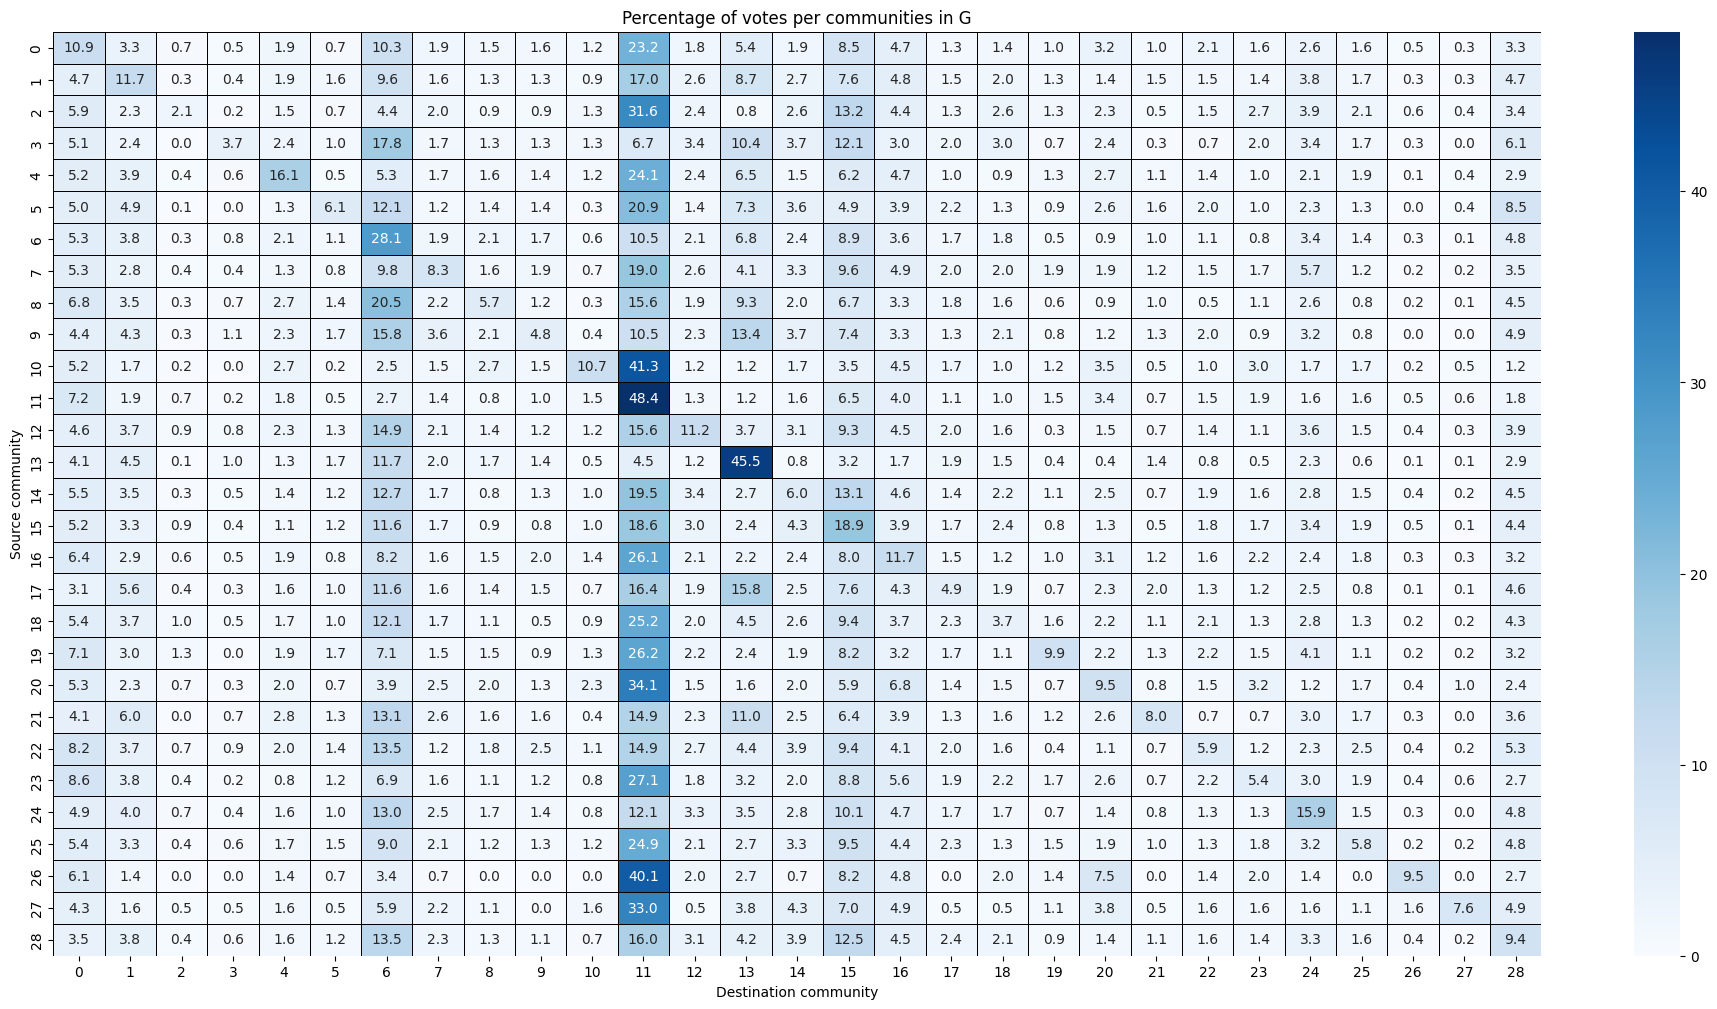

In [21]:
# Heatmap of the ratio of votes across communities
plt.figure(figsize=(24, 12))
sns.heatmap(ratio_vote_count_matrix, cmap="Blues", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

To mitigate this domination of the large communities, we scale the results by the probability of a vote between two communities given that the votes are random. We display the ratio of effective votes over expected votes for each pair of communities.

In [22]:
# Create matrix that represents the probability of a vote between two communities
prob_vote_community_matrix = np.zeros((len(communities), len(communities)))
for i_src in range(len(communities)):
    for i_dst in range(len(communities)):
        prob_vote_community_matrix[i_src][i_dst] = (len(communities[i_src])*len(communities[i_dst]))/(len(G)**2)
# create matrix that represents the expected number of votes between two communities
ratio_vote_expected_matrix = prob_vote_community_matrix * votes_in_the_graph

In [23]:
# populate the matrix of votes
vote_result_matrix = [[np.zeros(3) for i in range(len(communities))] for j in range(len(communities))]
nb_result_votes = np.zeros((len(communities), len(communities)))
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        if row['vote'] == 1:
            vote_result_matrix[i_src][i_dst][2] += 1
        elif row['vote'] == -1:
            vote_result_matrix[i_src][i_dst][0] += 1
        else:
            vote_result_matrix[i_src][i_dst][1] += 1
        nb_result_votes[i_src][i_dst] += 1


In [24]:
gain_vote_expected_matrix = np.nan_to_num(nb_result_votes / ratio_vote_expected_matrix)

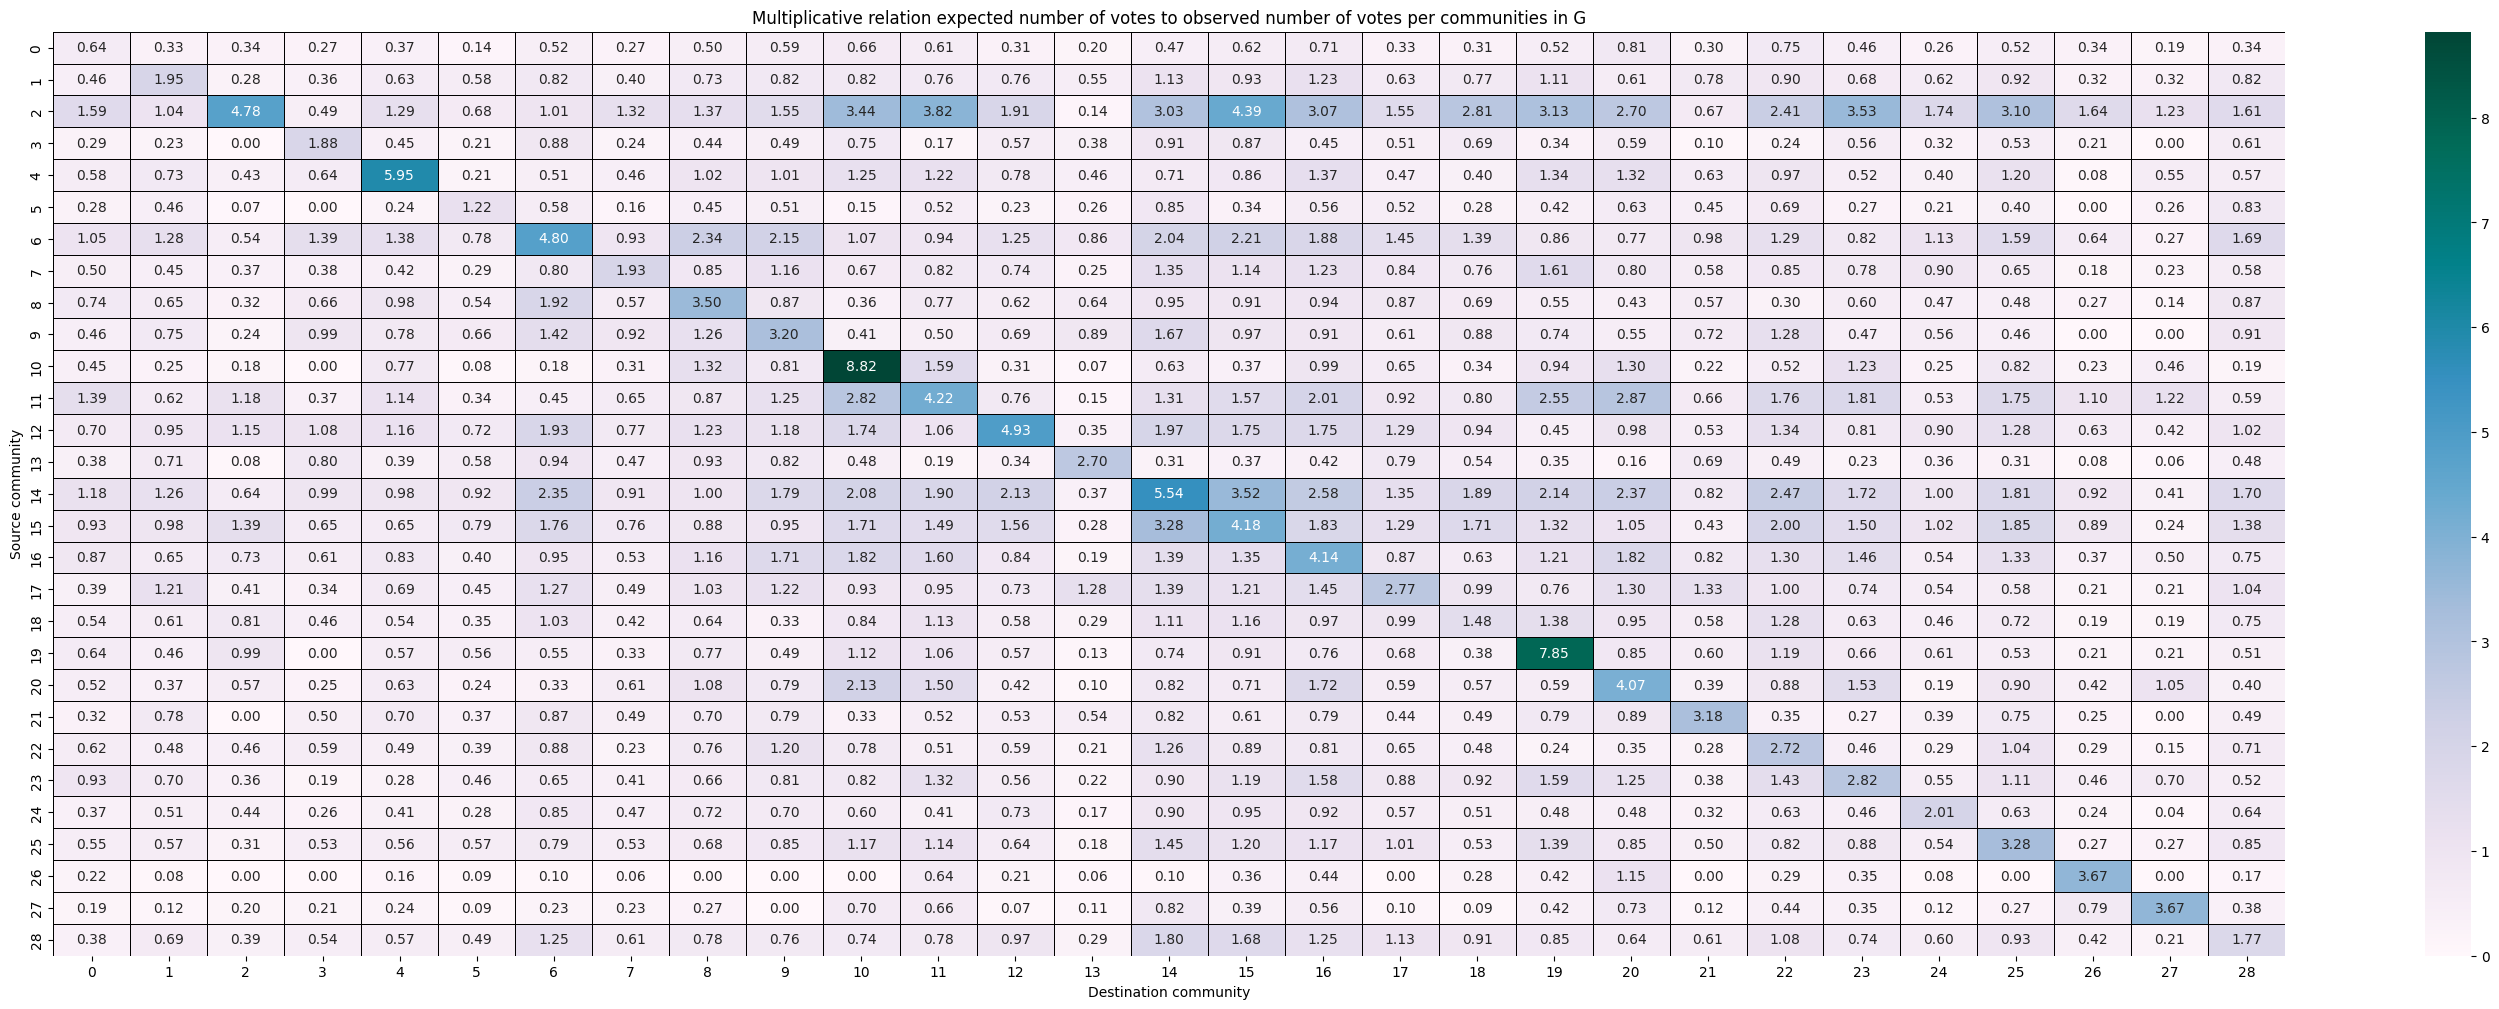

In [25]:
# Heatmap of the gain from expected votes across communities
# Couleurs sympas: 'PuBuGn', 'RdYlBu', 'coolwarm'
plt.figure(figsize=(36, 12))
sns.heatmap(gain_vote_expected_matrix, cmap='PuBuGn', annot=True, fmt=".2f", linewidths=.5, linecolor="black")
plt.title("Multiplicative relation expected number of votes to observed number of votes per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

The diagonal of the matrix has significantly higher values. This indicates that people tend to vote more for the people part of their community. We recall that the communities have been created with the interactions between the users and not the votes.

#### Can we find a rivalry between some communities? Maybe a community only vote negatively towards another community.

We want to know the voting habitudes of communities. For that we plot the result precentage per community

In [26]:
# populate the matrix of votes
vote_result_matrix = [[np.zeros(3) for i in range(len(communities))] for j in range(len(communities))]
nb_result_votes = np.zeros((len(communities), len(communities)))
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        if row['vote'] == 1:
            vote_result_matrix[i_src][i_dst][2] += 1
        elif row['vote'] == -1:
            vote_result_matrix[i_src][i_dst][0] += 1
        else:
            vote_result_matrix[i_src][i_dst][1] += 1
        nb_result_votes[i_src][i_dst] += 1


In [27]:
vote_result_matrix = np.nan_to_num((vote_result_matrix / nb_result_votes[:,:,np.newaxis]))*100

C:\Users\danie\AppData\Local\Temp\ipykernel_23256\1177325575.py:1: RuntimeWarning: invalid value encountered in divide
  vote_result_matrix = np.nan_to_num((vote_result_matrix / nb_result_votes[:,:,np.newaxis]))*100


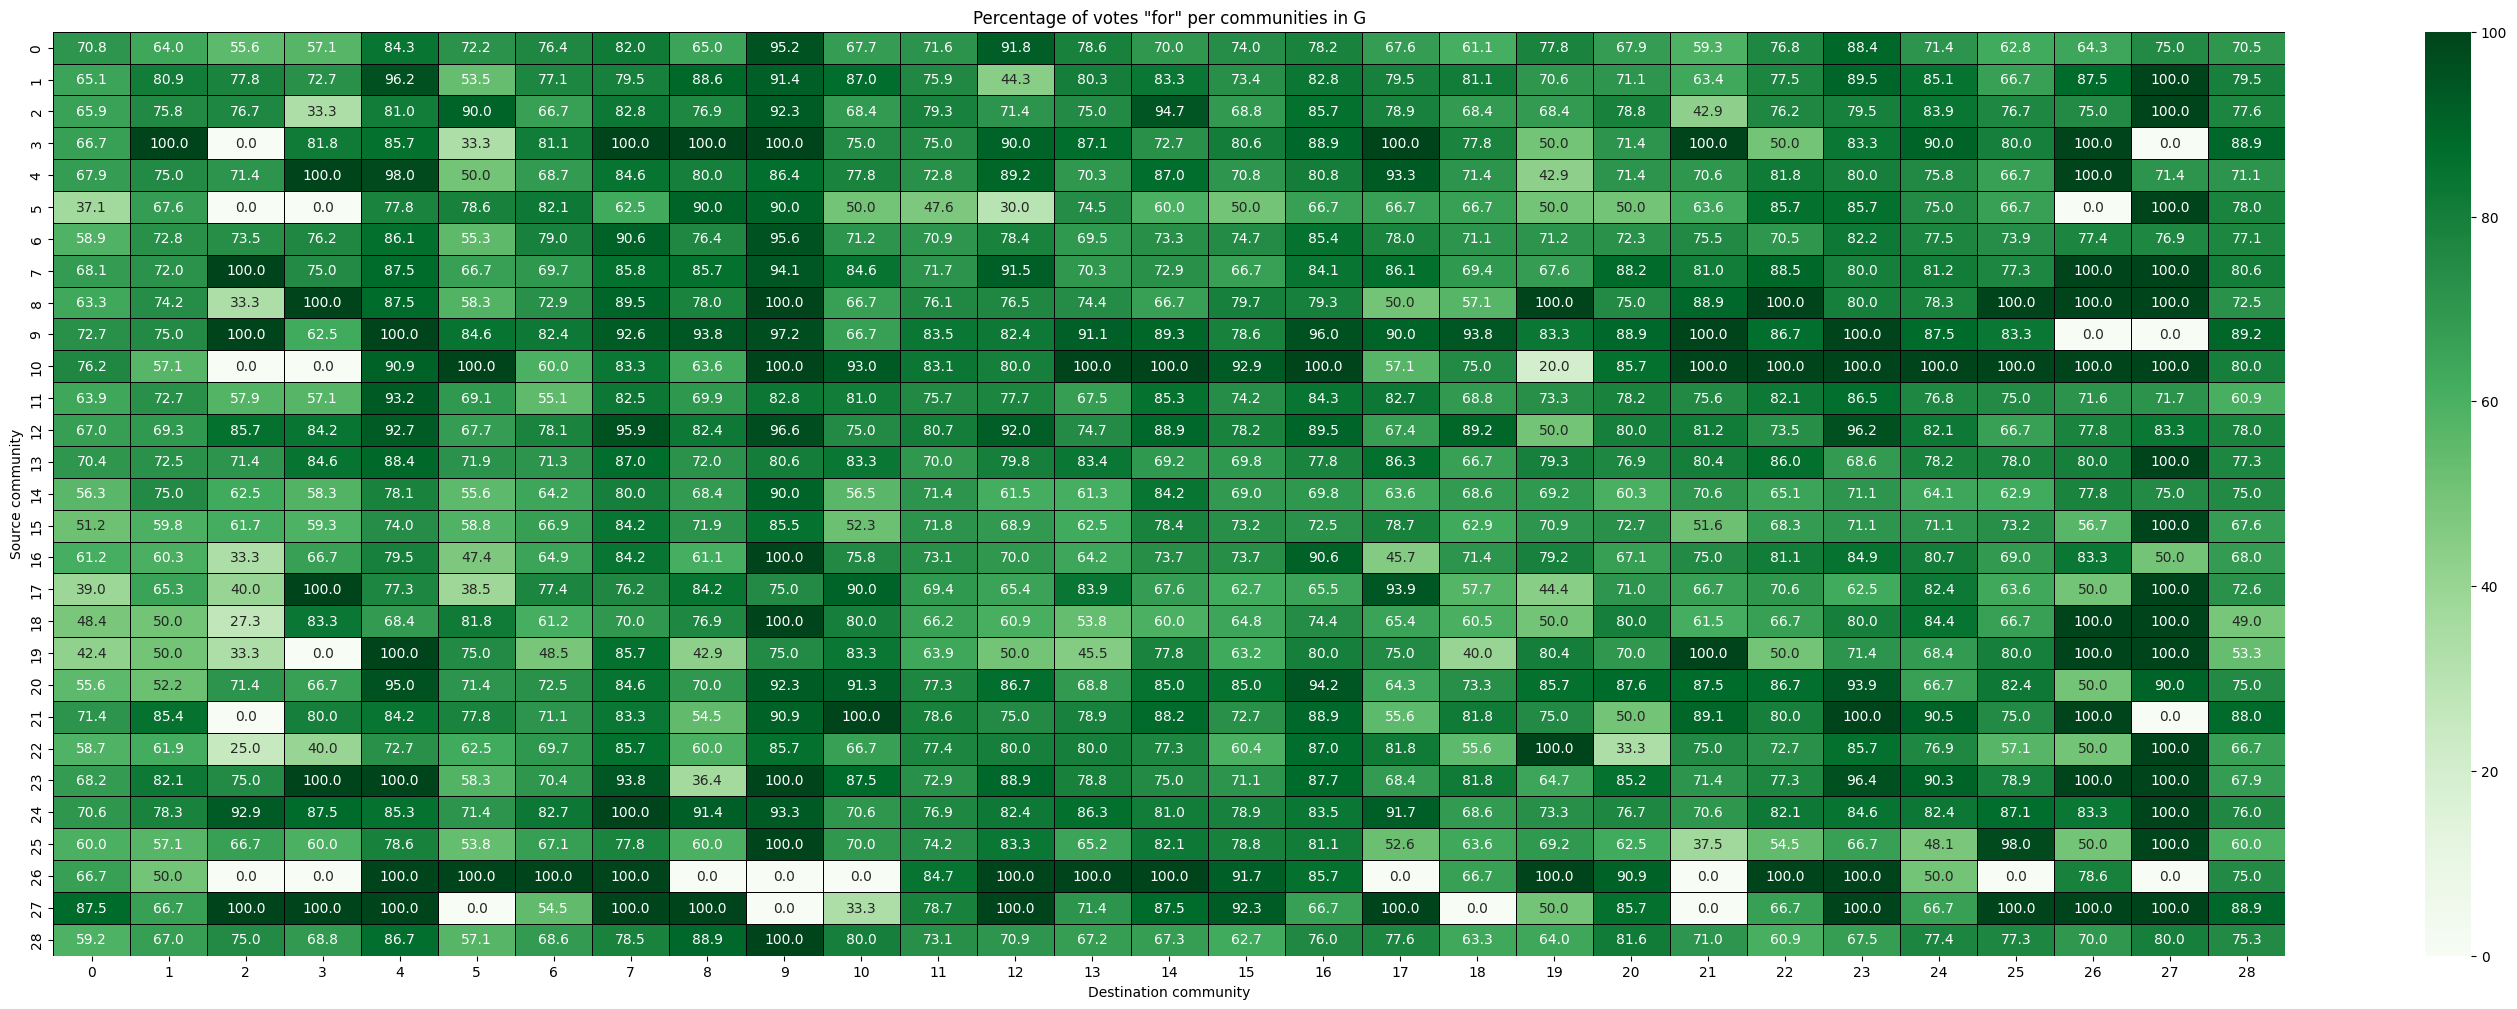

In [28]:
for_ratio_result_matrix = vote_result_matrix[:,:,2]
plt.figure(figsize=(36, 12))
sns.heatmap(for_ratio_result_matrix, cmap="Greens", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"for\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

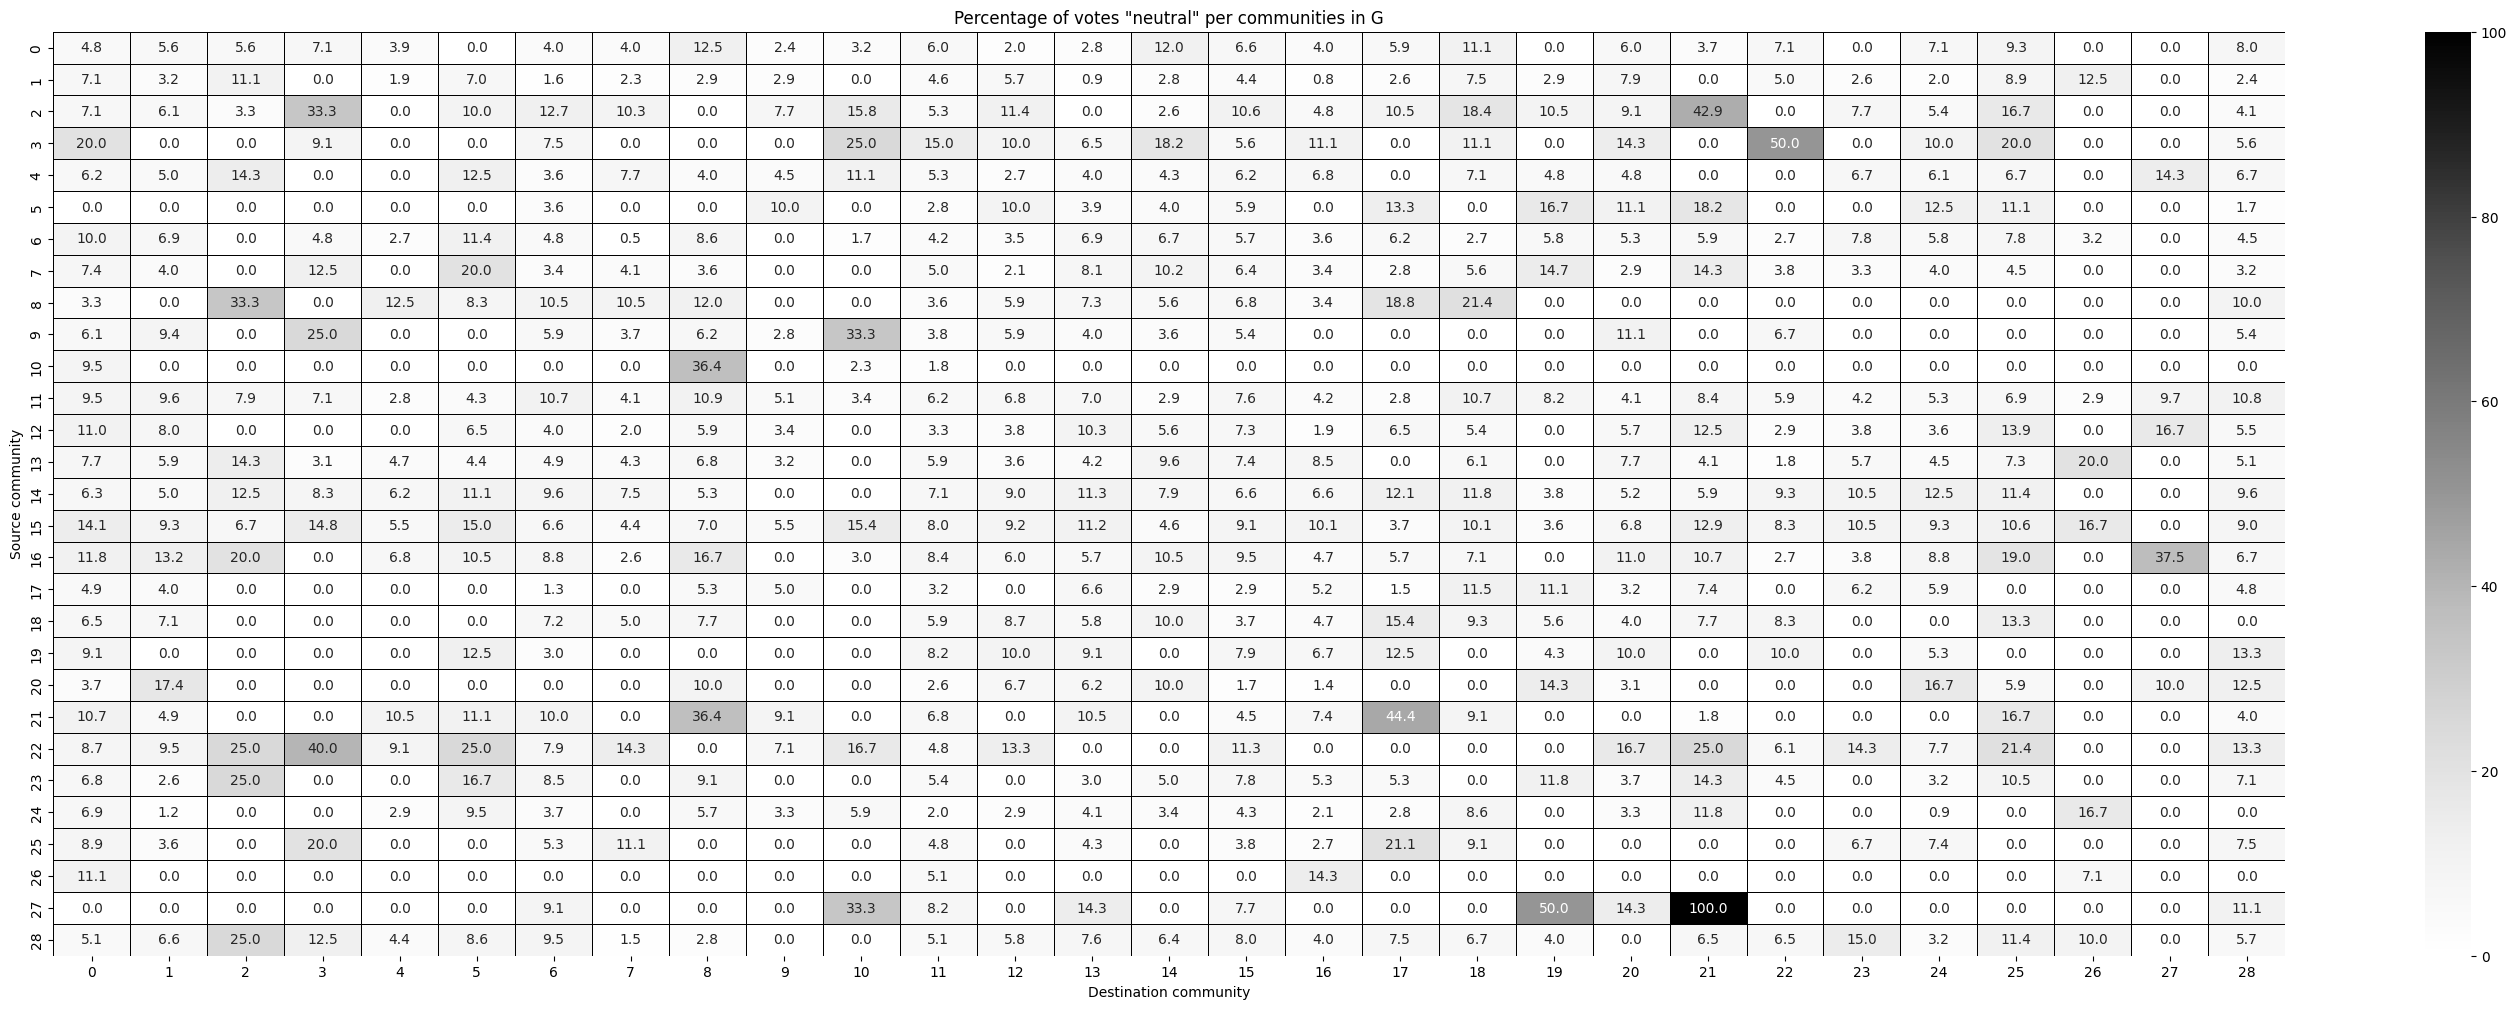

In [29]:
neutral_ratio_result_matrix = vote_result_matrix[:,:,1]
plt.figure(figsize=(36, 12))
sns.heatmap(neutral_ratio_result_matrix, cmap="Greys", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"neutral\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

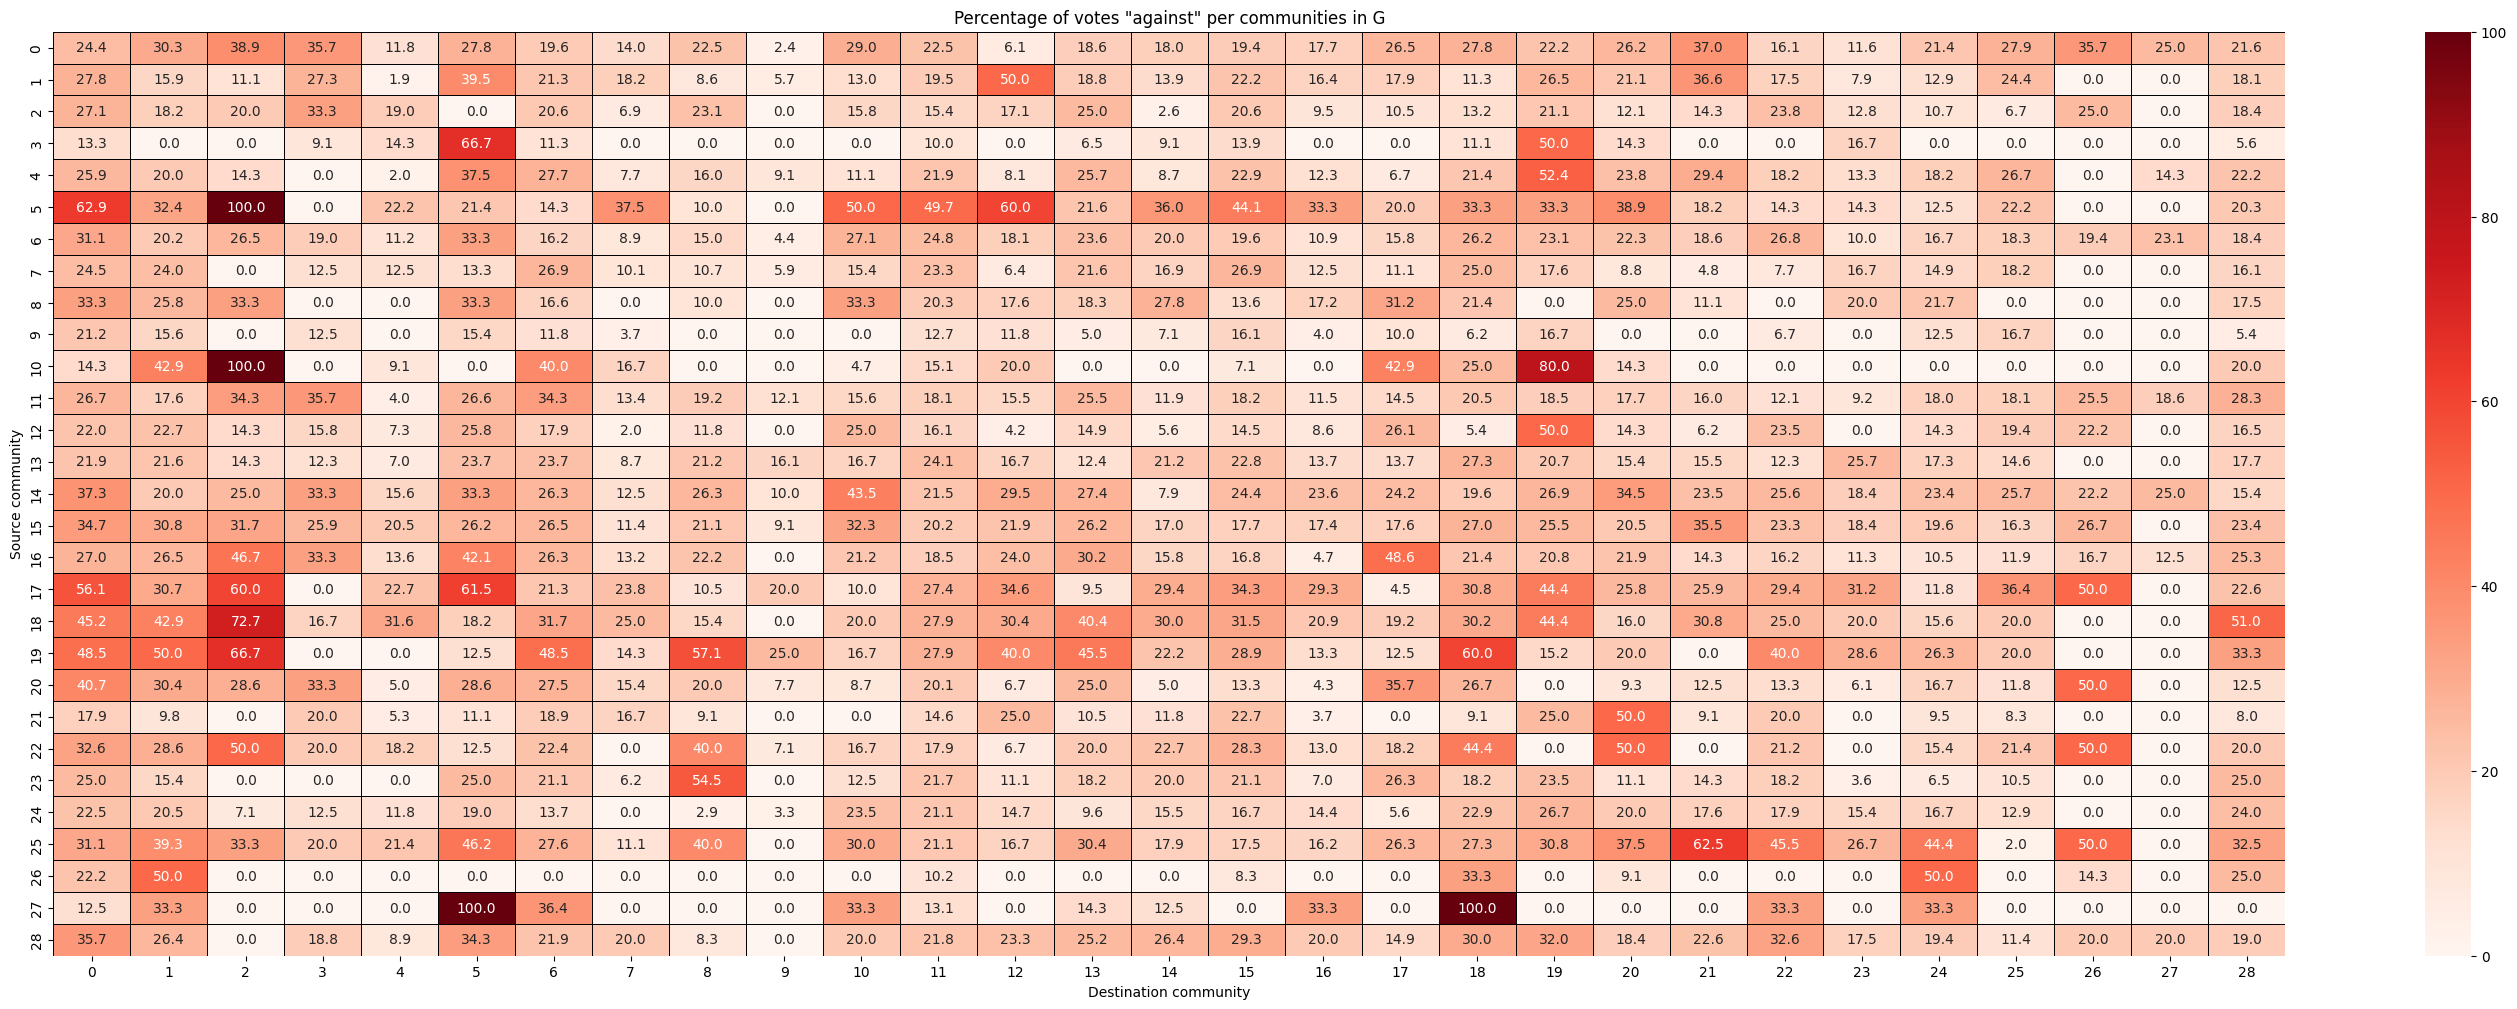

In [30]:
against_ratio_result_matrix = vote_result_matrix[:,:,0]
plt.figure(figsize=(36, 12))
sns.heatmap(against_ratio_result_matrix, cmap="Reds", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"against\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

We can observe that some communities display either a positive or negative bias in their voting preferences. If votes were at random and participation uniform accross communities, we would have expected that the portion of votes "for", "against" and "neutral" to have to same proportion between communities. Suspicious results could help us to inspect further the relationship between the two communities involved.

# Content of edits analysis <a class="anchor" id="edits"></a>

This section explores the relationship between the topics of Wikipedia pages edited by users and the occurrence of votes between two users. The goal is to identify potential correlations and patterns that would show that editing similar topics has an influence in the motivation to cast a vote.

### Setup <a class="anchor" id="edits_setup"></a>

In [31]:
# The original dataset can be found here (https://snap.stanford.edu/data/wiki-meta.html). 
# The version that we use here has already been modified so that we get each user and 
# the page they modified with the number of edits

edits_df = pd.read_csv("../data/interactions_edits_grouped.zip", index_col=0, compression='zip')
edits_df

,username,counts
article_title,,
!,MPerel,1
!!,Gracenotes,1
!!,Gwern,1
!!,JHunterJ,8
!!,Kane5187,1
...,...,...
ﻲ,Dbenbenn,1
ﻳ,Dbenbenn,1
ﻴ,Dbenbenn,1


In [32]:
# We create a list of Wikipedia pages modified by each users
user_indices = edits_df.groupby('username').apply(lambda x: x.index.tolist()).reset_index(name='Indices')
user_indices

,username,Indices
0,'sed,"[Bloody_Mary_(South_Park), Cartoon_Wars_Part_I..."
1,(.Y.),"[Blue_Water_High, List_of_bass_guitarists, Lis..."
2,(:Julien:),"[1993_Russian_constitutional_crisis, 1999_NBA_..."
3,(aeropagitica),"['Aho'eitu, 'Ilaheva, ...Und_Morgen_Fliegen_Wi..."
4,*Kat*,"[&_Yet_&_Yet, *MTV, .nc.tr, 1670, 1964_(emulat..."
...,...,...
6586,^demon,"[""Comedy_Time""_Ganesh, ""Them""_(King_Diamond_al..."
6587,~K,"[(Bis(trifluoroacetoxy)iodo)benzene, 1,2,4-Tri..."
6588,Вasil,"[1809, 1870, 1877, 1964_Minnesota_Twins_season..."
6589,Еdit,"[1600_Pennsylvania_Avenue_(musical), 2005_Atla..."


In [33]:
# Create a list of all users present in the edits dataset
users = set(edits_df['username'].tolist())

Create a matrix with the Jaccard index (on the the lists of modified pages) for all pairs of users. Jaccard index "[is a statistic used for gauging the similarity and diversity of sample sets](https://en.wikipedia.org/wiki/Jaccard_index)". It will be used to understand the similarity of edited pages between pairs of users.

In [34]:
matrix_similarity = pd.read_csv("../data/jaccard.csv.zip", index_col=0, compression='zip')
matrix_similarity

,Bellhalla,Complainer,Werdan7,Grön,Weasel,Filll,Thejerm,Cyclone1,RJFJR,Mkweise,...,UtherSRG,Pyrop,AngelOfSadness,Clarkk,Appleboy,Voyaging,JLaTondre,InShaneee,Ed,Advanced
Bellhalla,1.000000,0.000173,0.000808,0.000000,0.000000,0.000579,0.000315,0.000173,0.001307,0.000426,...,0.001782,0.000296,0.001437,0.000543,0.000334,0.000000,0.004429,0.001600,0.000168,0.000000
Complainer,0.000173,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000492,0.000000,0.000369,0.000000,0.000000,0.000000,0.000098,0.000000,0.000000,0.000000
Werdan7,0.000808,0.000000,1.000000,0.000000,0.000000,0.001804,0.000000,0.000000,0.000596,0.002238,...,0.001802,0.002651,0.008425,0.000504,0.009511,0.002049,0.002832,0.006304,0.004392,0.005298
Grön,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000104,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003106,0.000000,0.000196,0.000324,0.000000,0.000000
Weasel,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000195,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Voyaging,0.000000,0.000000,0.002049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003484,1.000000,0.000197,0.000327,0.004348,0.000000
JLaTondre,0.004429,0.000098,0.002832,0.000196,0.000195,0.001678,0.002697,0.000000,0.005550,0.004555,...,0.008998,0.002688,0.009551,0.002571,0.002116,0.000197,1.000000,0.011813,0.000676,0.000959
InShaneee,0.001600,0.000000,0.006304,0.000324,0.000000,0.004031,0.003552,0.000644,0.005090,0.007861,...,0.007856,0.006660,0.014829,0.001686,0.009451,0.000327,0.011813,1.000000,0.001847,0.001505
Ed,0.000168,0.000000,0.004392,0.000000,0.000000,0.000711,0.000000,0.000000,0.000408,0.001306,...,0.000549,0.001596,0.001755,0.000270,0.006224,0.004348,0.000676,0.001847,1.000000,0.002000


Create a DataFrame with all pairs of users and a binary variable that indicates if a vote exists for each pair. It will be helpful to computes the correlation between similarity in edited pages and voting interaction between two users.

In [35]:
similarity_and_vote = pd.read_csv("../data/jaccard_and_votes.csv.zip", index_col=0, compression='zip')
similarity_and_vote

,vote,jaccard
"('Bellhalla', 'Complainer')",0,0.000173
"('Bellhalla', 'Werdan7')",0,0.000808
"('Bellhalla', 'Grön')",0,0.000000
"('Bellhalla', 'Weasel')",0,0.000000
"('Bellhalla', 'Filll')",0,0.000579
...,...,...
"('JLaTondre', 'Ed')",0,0.000676
"('JLaTondre', 'Advanced')",0,0.000959
"('InShaneee', 'Ed')",0,0.001847
"('InShaneee', 'Advanced')",0,0.001505


### Statistics <a class="anchor" id="edits_statistics"></a>

Now we will compute some statistics on this data.

In [36]:
pearsonr(similarity_and_vote['vote'], similarity_and_vote['jaccard'])

PearsonRResult(statistic=0.08914982798277882, pvalue=0.0)

The correlation between similarity score on edited pages and the votes is not very strong but positive with high significance.

In [37]:
# Mean similarity between all pairs of users
mean_sim_all = similarity_and_vote['jaccard'].mean()
mean_sim_all

0.0012019944311329655

In [38]:
# Mean similarity between pairs of users that are linked by a vote
mean_sim_vote = similarity_and_vote[similarity_and_vote['vote'] == 1]['jaccard'].mean()
mean_sim_vote

0.005487495987236598

In [39]:
print(f"People that are linked by a vote have {mean_sim_vote / mean_sim_all:.2f} times more common edited pages than the average.")

People that are linked by a vote have 4.57 times more common edited pages than the average.


### Investigation of most edited pages <a class="anchor" id="edits_investigation"></a>

We investigate most edited pages per community. The goal is to find a common topic that could define community's interest.

In [40]:
for count, community in enumerate(communities):
    community_to_check = community
    
    user_list = list(user_indices['username'])
    all_subject = set()
    for user in community_to_check:
        if user in user_list:
            all_subject = set(user_indices[user_indices['username'] == user]['Indices'].iloc[0]).union(all_subject)
            
    data = pd.DataFrame(index=list(all_subject), columns=['count'])
    data = data.fillna(0)
    
    for user in community_to_check:
        if user in user_list:
            subjects = user_indices[user_indices['username'] == user]['Indices'].iloc[0]
            for s in subjects:
                data.at[s, 'count'] += 1
    print(f"Community {count}:")            
    print(data.sort_values('count', ascending = False).head(20))

Community 0:
                     count
Britney_Spears          56
George_W._Bush          54
Wikipedia               51
PlayStation_3           45
United_States           41
David_Beckham           40
Adolf_Hitler            39
Wii                     39
2006_FIFA_World_Cup     37
The_Beatles             37
Paris_Hilton            37
Bill_Clinton            36
Christina_Aguilera      36
24_(TV_series)          36
World_War_II            35
Hurricane_Katrina       35
Family_Guy              34
Green_Day               34
Xbox                    34
McDonald's              33
Community 1:
                                               count
Muhammad                                          60
Israel                                            55
Jerusalem                                         54
Islam                                             53
2006_Lebanon_War                                  52
The_Holocaust                                     50
Jesus                               